# Homework 2
## Josias Moukpe
### 10-2-2023

### Instructions

Submit **one** Python notebook file for grading. Your file must include **text explanations** of your work, **well-commented code**, and the **outputs** from your code.

### Problems

#### Gradients

1. [10 points] Consider a single neuron with 3 inputs and PReLU activation function. Find the mathematical formula for the gradient of the activated output with respect to its incoming weights **and** the learnable PReLU parameter.

A single neuron with 3 inputs and PReLU activation function is formalized as follows:
$$ 
z = w_1x_1 + w_2x_2 + w_3x_3 + w_0 
$$ where $w_0$ is the bias and $w_i$ are the weights of the $i$-th input $x_i$. the output $y$ after activation is then given by:
$$ y = f(z) = \begin{cases} az, & \text{ if } z < 0 \\ z, & \text{ if } z \geq 0 \end{cases} $$
where $a$ is a learnable parameter, $z$ is the net output of the neuron and $y$ is the output prediction.
The gradient of the output $y$ with respect to the weights are given by:
$$ \frac{\partial y}{\partial w_i} = \frac{\partial f(z)}{\partial w_i} = \frac{\partial f(z)}{\partial z} \cdot \frac{\partial z}{\partial w_i} $$ 
Considering $x_0 = 1$, then we know $$ \frac{\partial z}{\partial w_i} = x_i $$  and 
$$ \frac{\partial f(z)}{\partial z} = \begin{cases} a, & \text{ if } z < 0 \\ 1, & \text{ if } z \geq 0 \end{cases} $$
Therefore, the gradients of $y$ with respect to $w_0$, $w_1$, $w_2$, and $w_3$ are given by:
$$ \frac{\partial y}{\partial w_i} = \begin{cases} ax_i, & \text{ if } z < 0 \\ x_i, & \text{ if } z \geq 0 \end{cases} \quad \text{for } i \in \{0, 1, 2, 3\} $$

The gradient of the output $y$ with respect to the learnable PReLU parameter $a$ is given by:
$$ \frac{\partial y}{\partial a} = \frac{\partial f(z)}{\partial a} = \begin{cases} z, & \text{ if } z < 0 \\ 0, & \text{ if } z \geq 0 \end{cases} $$


#### Dense Neural Networks

2. [40 points]. Use a feedforward NN with SGD to classify the CIFAR-10 dataset, and tune its hyperparameters as best you can. **You must use Keras or PyTorch**. Requirements below.

Randomly split the dataset into 60\%/20/\%/20\% training/validation/testing sets. When tuning hyperparameters, test on the validation set. After you find the best hyperparameters, run your code **once** with these settings on the test. Use `random_state = 1` before splitting data.

Start with a 1-node classifier as a benchmark.

You must run **at least one experiment** using all major techniques (5 points each):

* Normalization/Standardization
* Weight Initialization
* Architectures
* Activation functions
* Loss functions
* Regularization (must include dropout)

**For each experiment, document why you chose to run this experiment, training accuracy/loss, validation accuracy/loss, epoch number with best validation accuracy (see the `EarlyStopping` callback), and training runtime.**

Training takes significant time, so brute force is *not* feasible. Make *informed decisions* on how to proceed and write your reasoning in your report. Include all fruitful experiments you run along the way. More importantly than the results, I want to see that you are *thinking well* and making good decisions. Good results will come from eventually if you *understand what you are doing*.

**Explanations and reasoning for your progression = [10 points]**

**Recommended:** Use small training sets for your initial tests so it works more quickly and then scale up when you results get better.

**Bonus:** Top 3 highest classification accuracy submissions earn +5 points.

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### Setup and Imports

In [1]:
#imports 
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from einops import rearrange
# from torchviz import make_dot
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.utils.data as data
import time
# import math
from typing import List, Any, Optional
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# setting up the random state 
seed = 1
# Set seed for numpy
np.random.seed(seed)
# Set seed for python random
random.seed(seed)
# Set seed for PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed(seed)

In [3]:
# check if GPU is available
if torch.cuda.is_available():
    # Get the name of the GPU
    gpu_name = torch.cuda.get_device_name(0)
    print(f'GPU available: {gpu_name}')
else:
    print('No GPU available. Defaulting to CPU.')

GPU available: NVIDIA GeForce RTX 3060


### Analyzing the data

In [4]:
# Define the transform for geting the tensors and normalizing the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
def imshow(img: torch.Tensor) -> None:
    """Display an image tensor.
    
    Parameters:
        img (torch.Tensor): The image tensor to display.
    """
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def display_examples(dataset: data.Dataset, num_examples: int = 10) -> None:
    """Display a number of random examples from a dataset.
    
    Parameters:
        dataset (torch.utils.data.Dataset): The dataset to display examples from.
        num_examples (int, optional): The number of examples to display. Default is 10.
    """
    indices = torch.randint(0, len(dataset), (num_examples,))
    images, labels = zip(*[dataset[i] for i in indices])
    images = torch.stack(images)
    imshow(torchvision.utils.make_grid(images))

In [6]:
class OneHotEncodedCIFAR10(data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        one_hot_label = F.one_hot(torch.tensor(label), num_classes=10)
        return image, one_hot_label

In [7]:
# Load the CIFAR-10 dataset
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


Files already downloaded and verified


In [8]:

# Apply one-hot encoding to the dataset
ohe_dataset = OneHotEncodedCIFAR10(dataset)

# Get the lengths of the subtraining, validation, and testing sets
total_len = len(ohe_dataset)
subtrain_len = int(total_len * 0.6)
validation_len = int(total_len * 0.2)
test_len = total_len - subtrain_len - validation_len

# Randomly split the dataset
subtrain_set, val_set, test_set = data.random_split(ohe_dataset, [subtrain_len, validation_len, test_len])
# Combine subtraining and validation sets to form the training set
training_set = data.ConcatDataset([subtrain_set, val_set])
# dataset = {training_set={subtraining_set, val_set}, test_set}

In [9]:
def compute_statistics(loader: data.DataLoader) -> tuple:
    """
    Compute the mean and standard deviation of a dataset.
    
    Parameters:
        loader (DataLoader): The DataLoader for the dataset.
        
    Returns:
        tuple: A tuple containing the mean and standard deviation.
    """
    total_images = 0
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for images, _ in loader:
        total_images += images.size(0)
        mean += images.mean(dim=[0, 2, 3])
        std += images.std(dim=[0, 2, 3])
    mean /= total_images
    std /= total_images
    return mean, std


# Create a DataLoader for the entire dataset
loader = data.DataLoader(dataset, batch_size=128, shuffle=False)

# Compute and print the statistics
mean, std = compute_statistics(loader)
print(f'Mean: {mean}, Standard Deviation: {std}')

Mean: tensor([-0.0001, -0.0003, -0.0008]), Standard Deviation: tensor([0.0039, 0.0038, 0.0041])


Class 6/frog: 5000
Class 9/truck: 5000
Class 4/deer: 5000
Class 1/automobile: 5000
Class 2/bird: 5000
Class 7/horse: 5000
Class 8/ship: 5000
Class 3/cat: 5000
Class 5/dog: 5000
Class 0/airplane: 5000


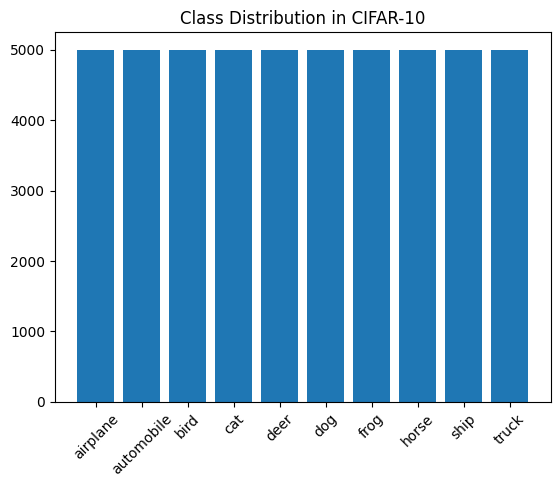

In [10]:
def get_class_distribution(dataset: data.Dataset) -> dict:
    """
    Compute the class distribution of a dataset.
    
    Parameters:
        dataset (torch.utils.data.Dataset): The dataset to analyze.
        
    Returns:
        dict: A dictionary where keys are class indices and values are counts.
    """
    class_counts = {}
    for _, label in dataset:
        label = int(label)
        class_counts[label] = class_counts.get(label, 0) + 1
    return class_counts


# Get class distribution
class_distribution = get_class_distribution(dataset)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Print class distribution
for class_index, count in class_distribution.items():
    print(f'Class {class_index}/{class_labels[class_index]}: {count}')

counts = [class_distribution[i] for i in range(len(class_labels))]

plt.bar(class_labels, counts)
plt.xticks(rotation=45)
plt.title('Class Distribution in CIFAR-10')
plt.show()

In [11]:
# dataset looks to be very balanced
sample, label = dataset[0][:2]
input_shape = dataset[0][0].size()
# Print the first sample and label
print(f'First Sample: {sample}')
print(f'Label Value: {label}')
print(f'Input Shape: {input_shape}')

First Sample: tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
         [-0.8431, -1.0000, -1.

In [12]:
def get_value_range(dataset: data.Dataset) -> tuple:
    """
    Obtain the range of values in a dataset.
    
    Parameters:
        dataset (torch.utils.data.Dataset): The dataset to inspect.
        
    Returns:
        tuple: A tuple containing the minimum and maximum values.
    """
    min_value = float('inf')
    max_value = float('-inf')
    for sample, _ in dataset:
        min_value = min(min_value, torch.min(sample).item())
        max_value = max(max_value, torch.max(sample).item())
    return min_value, max_value


# Get and print the range of values for the training set
min_value, max_value = get_value_range(dataset)
print(f'Value Range: {min_value} to {max_value}')

Value Range: -1.0 to 1.0


### Applying benchmark classifier

In [13]:
# Capture all the hyperparameters in a dictionary
Hyperparams = {
    'learning_rate': 3e-3,
    'batch_size': 64,
    'num_epochs': 500,
    'optimizer': 'SGD',
    'momentum': 0.9,
    'patience': 5
}

In [14]:
# Define the 1-node hidden layer classifier
class Classifier(nn.Module):
    def __init__(self,
                 input_size: int,
                 num_classes: int,
                 hidden_layers: list,
                 init_method: str = 'lecun_uniform',
                 activation_function: nn.Module = nn.LeakyReLU(),
                 dropout: float = None,
                 normalization: str = None):
        """
        Initialize the layers of the classifier.
        
        Parameters:
            input_size (int): The number of features in the input data.
            num_classes (int): The number of classes in the dataset.
            hidden_layers (list): List of integers representing the number of units in each hidden layer.
            init_method (str): The weight initialization method ('lecun_uniform', 'lecun_normal', 
                               'xavier_uniform', 'xavier_normal', 'kaiming_uniform', or 'kaiming_normal').
            activation_function (nn.Module): Activation function instance to use. Default is LeakyReLU.
            dropout (float): Dropout rate (0 to 1), if dropout is to be applied. None for no dropout.
            normalization (str): Type of normalization ('batch', 'layer', or None).
        """
        super(Classifier, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes

        layers = []
        in_features = input_size  # Input size to the first hidden layer

        # Function to initialize weights
        def init_weights(m):
            if type(m) == nn.Linear:
                if init_method == 'lecun_uniform':
                    pass  # LeCun uniform initialization is the default for nn.Linear
                else:
                    if isinstance(activation_function, nn.LeakyReLU):
                        nonlinearity = 'leaky_relu'
                        a = activation_function.negative_slope  # Get the negative slope from LeakyReLU
                    elif isinstance(activation_function, nn.PReLU):
                        nonlinearity = 'leaky_relu'  # PReLU is also a type of leaky ReLU
                        a = activation_function.weight.item()  # Get the negative slope from PReLU
                    else:
                        raise ValueError(f'Unsupported activation function: {activation_function}')

                    if init_method.endswith('uniform'):
                        gain = nn.init.calculate_gain(nonlinearity, a)
                        nn.init.xavier_uniform_(m.weight, gain=gain) if 'xavier' in init_method else \
                            nn.init.kaiming_uniform_(m.weight, a=a, mode='fan_in',
                                                     nonlinearity=nonlinearity) if 'kaiming' in init_method else None
                    else:  # normal initialization
                        std = nn.init.calculate_gain(nonlinearity, a)
                        nn.init.xavier_normal_(m.weight, std=std) if 'xavier' in init_method else \
                            nn.init.kaiming_normal_(m.weight, a=a, mode='fan_in',
                                                    nonlinearity=nonlinearity) if 'kaiming' in init_method else \
                                nn.init.normal_(m.weight, std=1.0)  # lecun_normal

        # Create hidden layers
        for out_features in hidden_layers:
            linear_layer = nn.Linear(in_features, out_features)
            linear_layer.apply(init_weights)
            layers.append(linear_layer)
            if normalization == 'batch':
                layers.append(nn.BatchNorm1d(out_features))
            elif normalization == 'layer':
                layers.append(nn.LayerNorm(out_features))
            layers.append(activation_function)
            if dropout:
                layers.append(nn.Dropout(dropout))
            in_features = out_features  # Update in_features for the next layer

        # Output layer
        output_layer = nn.Linear(in_features, num_classes)
        output_layer.apply(init_weights)
        layers.append(output_layer)

        self.layers = nn.Sequential(*layers)  # Create a sequential container from the layers list

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Define the forward pass through the network.
        
        Parameters:
            x (torch.Tensor): The input data.
            
        Returns:
            torch.Tensor: The output of the network.
        """
        x = x.view(-1, self.input_size)
        x = self.layers(x)  # Apply the layers to the input data
        return x

    def save_model(self, path: str):
        """
        Save the trained parameters of the network to a file.
        
        Parameters:
            path (str): The file path to save the trained parameters.
        """
        torch.save(self.state_dict(), path)
        print(f'Model parameters saved to {path}')

    @classmethod
    def load_model(cls, path: str, input_size: int, num_classes: int, hidden_layers: list):
        """
        Load the trained parameters into a new network.
        
        Parameters:
            path (str): The file path to load the trained parameters from.
            input_size (int): The number of features in the input data.
            num_classes (int): The number of classes in the dataset.
            hidden_layers (list): List of integers representing the number of units in each hidden layer.
            
        Returns:
            OneNodeClassifier: A new network with the loaded trained parameters.
        """
        model = cls(input_size, num_classes, hidden_layers)
        model.load_state_dict(torch.load(path))
        print(f'Model parameters loaded from {path}')
        return model

    def plot_model(self):
        """
        Display the summary and plot the network.
        """
        # input_size is already the product of C*H*W
        input_size = (self.input_size,)

        original_device = next(self.parameters()).device  # Store the original device
        self.to('cpu')  # Temporarily move model to CPU

        summary(self, input_size=input_size, device='cpu')  # Print summary

        # x = torch.randn(1, *input_size, device='cpu')  # Create a random input tensor on the CPU
        # y = self(x)
        # dot = make_dot(y, params=dict(self.named_parameters()))  # Create computation graph
        # dot.render(format='png', filename='network_graph')  # Save computation graph to file
        # plt.imshow(plt.imread('network_graph.png'))  # Display computation graph
        # plt.axis('off')
        # plt.show()

        self.to(original_device)  # Move model back to its original device

    def predict(self, x: torch.Tensor, show_images: bool = False) -> torch.Tensor:
        """
        Predict the class probabilities and optionally show images with predictions.
        
        Parameters:
            x (torch.Tensor): The input data.
            show_images (bool): Whether to display images with predictions.
            
        Returns:
            torch.Tensor: The class probabilities.
        """
        class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        x = x.to(device)

        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            probabilities = F.softmax(logits, dim=1)
            predictions = torch.argmax(probabilities, dim=1)

            if show_images:
                for i, image in enumerate(x.cpu()):  # Move images back to CPU for displaying
                    plt.imshow(image.permute(1, 2, 0))  # Assume image tensor shape is (C, H, W)
                    plt.title(f'Predicted: {class_names[predictions[i]]} ({probabilities[i][predictions[i]]:.2f})')
                    plt.show()

        return probabilities

In [15]:
# Get the input size and number of classes from the dataset
input_size = np.prod(dataset[0][0].shape)
num_classes = len(dataset.classes)
# Create DataLoaders for the training and testing sets
train_loader = data.DataLoader(training_set, batch_size=Hyperparams['batch_size'], shuffle=True)
subtrain_loader = data.DataLoader(subtrain_set, batch_size=Hyperparams['batch_size'], shuffle=True)
val_loader = data.DataLoader(val_set, batch_size=Hyperparams['batch_size'], shuffle=False)
test_loader = data.DataLoader(test_set, batch_size=Hyperparams['batch_size'], shuffle=False)

In [16]:
# dispaly the first 10 examples of subtraining with labels
images, labels = next(iter(subtrain_loader))
print(f'Labels: {labels}')
print(f'Images: {images}')

Labels: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0,

In [17]:
# print shape of input samples and labels
print(f'Input Shape: {images.shape}')
print(f'Label Shape: {labels.shape}')

Input Shape: torch.Size([64, 3, 32, 32])
Label Shape: torch.Size([64, 10])


In [18]:
# Instantiate the model with the input size and number of classes
oneNodeModel = Classifier(input_size, num_classes, [1])
# plot the model
oneNodeModel.plot_model()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]           3,073
         LeakyReLU-2                    [-1, 1]               0
            Linear-3                   [-1, 10]              20
Total params: 3,093
Trainable params: 3,093
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [19]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Instantiate the optimizer using the learning rate from Hyperparams
optimizer = optim.SGD(oneNodeModel.parameters(), lr=Hyperparams['learning_rate'], momentum=Hyperparams['momentum'])

In [20]:
class EarlyStopping:
    """Early stops the training if validation accuracy doesn't improve after a given patience."""

    def __init__(self, patience: int = 5):
        self.patience = patience
        self.counter = 0
        self.best_acc = None  # Changed from best_loss to best_acc
        self.early_stop = False

    def __call__(self, val_acc: float):  # Changed parameter name from val_loss to val_acc
        if self.best_acc is None:
            self.best_acc = val_acc  # Changed from best_loss to best_acc
        elif val_acc < self.best_acc:  # Changed comparison from > to <
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_acc = val_acc  # Changed from best_loss to best_acc
            self.counter = 0

In [21]:
def train_epoch(model: nn.Module, data_loader: data.DataLoader, criterion: nn.Module, optimizer: optim.Optimizer) -> (
        float, float):
    """Train the model for one epoch."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        # Convert one-hot encoded labels to class indices
        labels = torch.argmax(labels, dim=1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(data_loader), correct / total


def validate_model(model: nn.Module, data_loader: data.DataLoader, criterion: nn.Module) -> (float, float):
    """Validate the model."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            # Convert one-hot encoded labels to class indices
            labels = torch.argmax(labels, dim=1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(data_loader), correct / total


def train_and_evaluate(model: nn.Module,
                       subtrain_loader: data.DataLoader,
                       val_loader: data.DataLoader,
                       train_loader: data.DataLoader,
                       criterion: nn.Module,
                       optimizer: optim.Optimizer,
                       hyperparams: dict) -> (int, float):
    """
    Train and evaluate the model to find the best epoch number on subtraining data, 
    then retrain on the entire training set with the best epoch number.

    Parameters:
        model (nn.Module): The model to be trained and evaluated.
        subtrain_loader (torch.utils.data.DataLoader): DataLoader for the subtraining data.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation data.
        train_loader (torch.utils.data.DataLoader): DataLoader for the entire training data.
        criterion (nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        hyperparams (dict): Dictionary of hyperparameters including 'num_epochs'.

    Returns:
        int: The best epoch number.
        float: The training runtime for the second phase.
    """

    # First phase: training on subtraining data and validating to find the best epoch number
    early_stopping = EarlyStopping(patience=Hyperparams['patience'])
    best_epoch = 0
    best_val_acc = 0.0

    # Lists to store loss and accuracy values
    subtrain_losses, subtrain_accuracies = [], []
    val_losses, val_accuracies = [], []
    train_losses, train_accuracies = [], []

    for epoch in range(hyperparams['num_epochs']):  # assuming a max of hyperparams['num_epochs'] for simplicity
        train_loss, train_acc = train_epoch(model, subtrain_loader, criterion, optimizer)
        val_loss, val_acc = validate_model(model, val_loader, criterion)
        subtrain_losses.append(train_loss)
        subtrain_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(
            f'Epoch {epoch}/{hyperparams["num_epochs"]}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        early_stopping(val_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Second phase: retraining on the entire training set with the best epoch number
    start_time = time.time()

    for epoch in range(best_epoch + 1):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        print(f'Epoch {epoch}/{best_epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

    training_runtime = time.time() - start_time

    # Plotting
    epochs_subtrain = list(range(1, len(subtrain_losses) + 1))
    epochs_train = list(range(1, len(train_losses) + 1))

    plt.figure(figsize=(10, 4))

    # Subtraining and Validation Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs_subtrain, subtrain_losses, label='Subtrain Loss')
    plt.plot(epochs_subtrain, val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Subtraining and Validation Losses')

    # Subtraining and Validation Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs_subtrain, subtrain_accuracies, label='Subtrain Accuracy')
    plt.plot(epochs_subtrain, val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.title('Subtraining and Validation Accuracies')

    plt.show()  # Show the plots for the first phase

    plt.figure(figsize=(10, 4))

    # Training Loss and Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_train, train_losses, label='Training Loss')
    plt.legend()
    plt.title('Training Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_train, train_accuracies, label='Training Accuracy')
    plt.legend()
    plt.title('Training Accuracy')

    plt.show()  # Show the plots for the second phase

    print(f'Best Epoch: {best_epoch}')
    print(f'Training Runtime: {training_runtime:.2f} seconds')

    return best_epoch, training_runtime


In [22]:
def get_predictions(model: nn.Module, data_loader: data.DataLoader) -> (torch.Tensor, torch.Tensor):
    """Get model predictions and true labels.
    
    Args:
        model (nn.Module): The trained model.
        data_loader (DataLoader): The DataLoader for the test set.

    Returns:
        tuple: A tuple containing the true labels and the predicted labels.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            labels = torch.argmax(labels, dim=1)  # Convert one-hot to class indices if necessary
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            all_labels.append(labels)
            all_preds.append(preds)
    return torch.cat(all_labels), torch.cat(all_preds)

In [23]:
def evaluate_and_plot(model: nn.Module, data_loader: data.DataLoader) -> None:
    """
    Evaluate the model on the given data loader, print a classification report,
    and plot a confusion matrix.

    Parameters:
        model (torch.nn.Module): The trained model.
        data_loader (torch.utils.data.DataLoader): The data loader containing the testing data.

    Returns:
        None
    """
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    # Get true labels and predicted labels
    true_labels, predicted_labels = get_predictions(model, data_loader)

    # Convert to numpy arrays for use with sklearn
    true_labels_np = true_labels.cpu().numpy()
    predicted_labels_np = predicted_labels.cpu().numpy()

    # Generate classification report
    report = classification_report(true_labels_np, predicted_labels_np, target_names=class_names, zero_division=0)
    print(report)

    # Generate confusion matrix
    cm = confusion_matrix(true_labels_np, predicted_labels_np)

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [24]:
def experiment_and_evaluate(model: nn.Module,
                            subtrain_loader: data.DataLoader,
                            val_loader: data.DataLoader,
                            criterion: nn.Module,
                            optimizer: optim.Optimizer,
                            hyperparams: dict) -> int:
    """
    Train on a third of the subtraining set and evaluate on the validation set 
    to run experiments on

    Parameters:
        model (nn.Module): The model to be trained and evaluated.
        subtrain_loader (torch.utils.data.DataLoader): DataLoader for the subtraining data.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation data.
        criterion (nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        hyperparams (dict): Dictionary of hyperparameters including 'num_epochs'.

    Returns:
        int: The best epoch number.
    """

    # Determine the number of batches to use for subtraining
    third_length = len(subtrain_loader.dataset) // 3
    truncated_dataset = data.Subset(subtrain_loader.dataset, indices=range(third_length))
    truncated_subtrain_loader = data.DataLoader(
        truncated_dataset,
        batch_size=subtrain_loader.batch_size,
        shuffle=True,
        num_workers=subtrain_loader.num_workers
    )

    early_stopping = EarlyStopping(patience=hyperparams['patience'])
    best_epoch = 0
    best_val_acc = 0.0

    # Lists to store loss and accuracy values
    subtrain_losses, subtrain_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(hyperparams['num_epochs']):
        train_loss, train_acc = train_epoch(model, truncated_subtrain_loader, criterion, optimizer)
        val_loss, val_acc = validate_model(model, val_loader, criterion)
        subtrain_losses.append(train_loss)
        subtrain_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(
            f'Epoch {epoch}/{hyperparams["num_epochs"]}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        early_stopping(val_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Plotting
    epochs_subtrain = list(range(1, len(subtrain_losses) + 1))

    plt.figure(figsize=(10, 4))

    # Subtraining and Validation Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs_subtrain, subtrain_losses, label='Subtrain Loss')
    plt.plot(epochs_subtrain, val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Subtrain and Validation Losses')

    # Subtraining and Validation Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs_subtrain, subtrain_accuracies, label='Subtrain Accuracy')
    plt.plot(epochs_subtrain, val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.title('Subtrain and Validation Accuracies')

    plt.show()  # Show the plots

    evaluate_and_plot(model, val_loader)

    print(f'Best Epoch: {best_epoch}')

    return best_epoch


In [25]:
# experiment and evaluate first phase
best_epoch = experiment_and_evaluate(
    model=oneNodeModel,
    subtrain_loader=subtrain_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

KeyboardInterrupt: 

Epoch 0/500, Train Loss: 2.0663, Train Acc: 0.1866, Val Loss: 2.0791, Val Acc: 0.1768
Epoch 1/500, Train Loss: 2.0560, Train Acc: 0.1855, Val Loss: 2.0681, Val Acc: 0.1827
Epoch 2/500, Train Loss: 2.0487, Train Acc: 0.1876, Val Loss: 2.0693, Val Acc: 0.1731
Epoch 3/500, Train Loss: 2.0437, Train Acc: 0.1880, Val Loss: 2.0598, Val Acc: 0.1778
Epoch 4/500, Train Loss: 2.0388, Train Acc: 0.1872, Val Loss: 2.0655, Val Acc: 0.1798
Epoch 5/500, Train Loss: 2.0371, Train Acc: 0.1877, Val Loss: 2.0616, Val Acc: 0.1701
Epoch 6/500, Train Loss: 2.0348, Train Acc: 0.1893, Val Loss: 2.0609, Val Acc: 0.1763
Early stopping
Epoch 0/2, Train Loss: 2.0397, Train Acc: 0.1869
Epoch 1/2, Train Loss: 2.0366, Train Acc: 0.1869


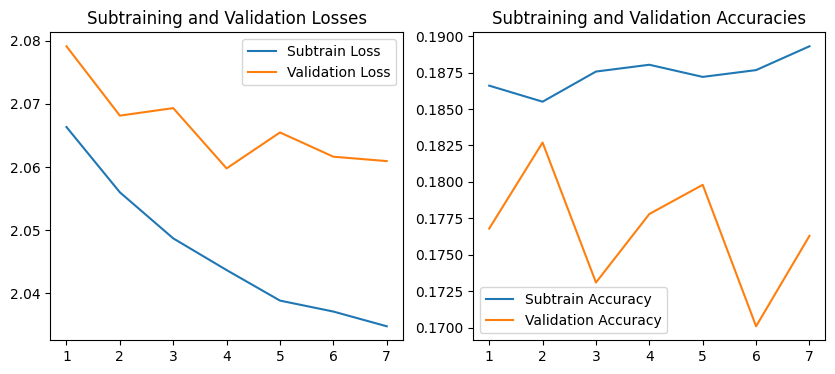

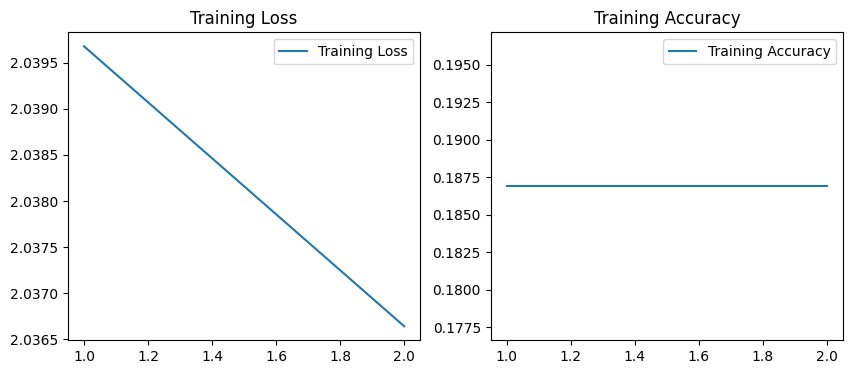

Best Epoch: 1
Training Runtime: 23.93 seconds


In [ ]:
# final benchmark training
best_epoch, training_runtime = train_and_evaluate(
    model=oneNodeModel,
    subtrain_loader=subtrain_loader,
    val_loader=val_loader,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00       999
  automobile       0.13      0.11      0.12       988
        bird       0.00      0.00      0.00      1002
         cat       0.00      0.00      0.00      1059
        deer       0.10      0.03      0.05       931
         dog       0.00      0.00      0.00      1032
        frog       0.20      0.75      0.31      1049
       horse       0.11      0.22      0.15       960
        ship       0.29      0.30      0.29       986
       truck       0.21      0.41      0.27       994

    accuracy                           0.18     10000
   macro avg       0.10      0.18      0.12     10000
weighted avg       0.10      0.18      0.12     10000



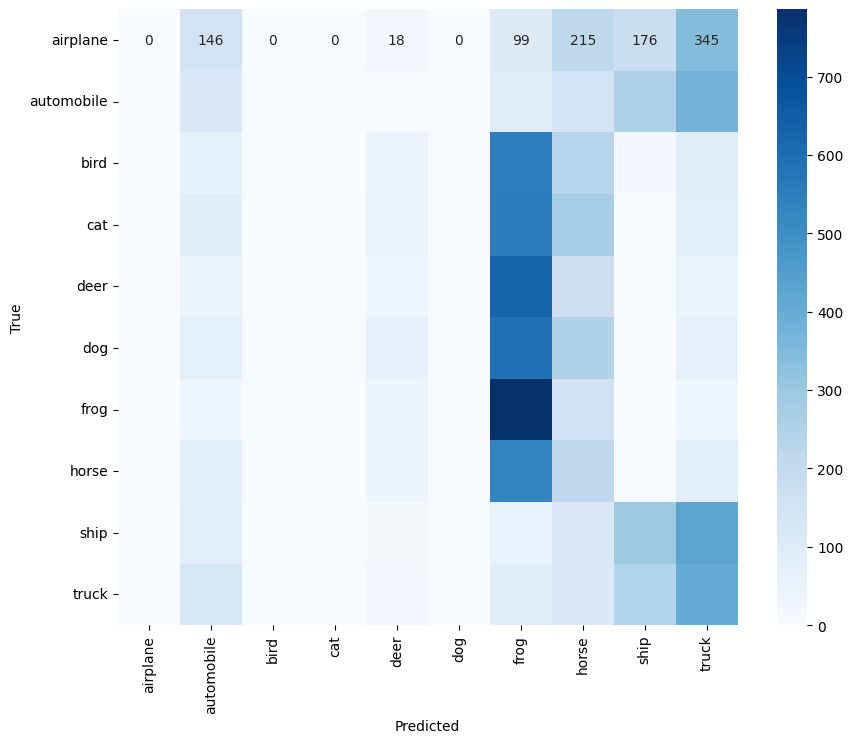

In [ ]:
evaluate_and_plot(oneNodeModel, test_loader)

The one node classifier is not very good with only 18% test accuracy

### Run some experiments on the CIFAR-10 dataset
0. Architectures (more hidden units)
1. Weight Initialization (Kaiming Normal)
2. Activation functions (PReLU)
3. Loss functions (focal loss)
4. Normalization/Standardization (batch normalization, layer normalization)
5. Regularization (a) weight decay/l2-regularization, (b) dropout, (c) data augmentations)
6. Ensembling (ensemble of top 3)
(Optional) Architectures (mlp-mixer)


### Experiment 0: we are going to add few more hidden units and test to see if the model performs better

In [ ]:
# more hidden units [2048, 1024, 512, 128, 64] so the features reduce
hidden_units = [2048, 1024, 512] 
# Instantiate the model with the input size and number of classes
model1 = Classifier(input_size, num_classes, hidden_units)
# plot the model
model1.plot_model()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
         LeakyReLU-2                 [-1, 2048]               0
            Linear-3                 [-1, 1024]       2,098,176
         LeakyReLU-4                 [-1, 1024]               0
            Linear-5                  [-1, 512]         524,800
         LeakyReLU-6                  [-1, 512]               0
            Linear-7                   [-1, 10]           5,130
Total params: 8,921,610
Trainable params: 8,921,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 34.03
Estimated Total Size (MB): 34.10
----------------------------------------------------------------


In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Instantiate the optimizer using the learning rate from Hyperparams
optimizer = optim.SGD(model1.parameters(), lr=Hyperparams['learning_rate'], momentum=Hyperparams['momentum'])

Epoch 0/500, Train Loss: 2.2519, Train Acc: 0.2161, Val Loss: 2.1624, Val Acc: 0.2440
Epoch 1/500, Train Loss: 2.0359, Train Acc: 0.2861, Val Loss: 1.9492, Val Acc: 0.2942
Epoch 2/500, Train Loss: 1.8589, Train Acc: 0.3385, Val Loss: 1.8114, Val Acc: 0.3578
Epoch 3/500, Train Loss: 1.7308, Train Acc: 0.3785, Val Loss: 1.7294, Val Acc: 0.3855
Epoch 4/500, Train Loss: 1.6365, Train Acc: 0.4167, Val Loss: 1.6712, Val Acc: 0.4095
Epoch 5/500, Train Loss: 1.5568, Train Acc: 0.4470, Val Loss: 1.6475, Val Acc: 0.4089
Epoch 6/500, Train Loss: 1.4907, Train Acc: 0.4703, Val Loss: 1.6126, Val Acc: 0.4233
Epoch 7/500, Train Loss: 1.4145, Train Acc: 0.4989, Val Loss: 1.6044, Val Acc: 0.4329
Epoch 8/500, Train Loss: 1.3402, Train Acc: 0.5289, Val Loss: 1.5825, Val Acc: 0.4451
Epoch 9/500, Train Loss: 1.2651, Train Acc: 0.5520, Val Loss: 1.5629, Val Acc: 0.4597
Epoch 10/500, Train Loss: 1.1878, Train Acc: 0.5844, Val Loss: 1.5804, Val Acc: 0.4552
Epoch 11/500, Train Loss: 1.1059, Train Acc: 0.6143, 

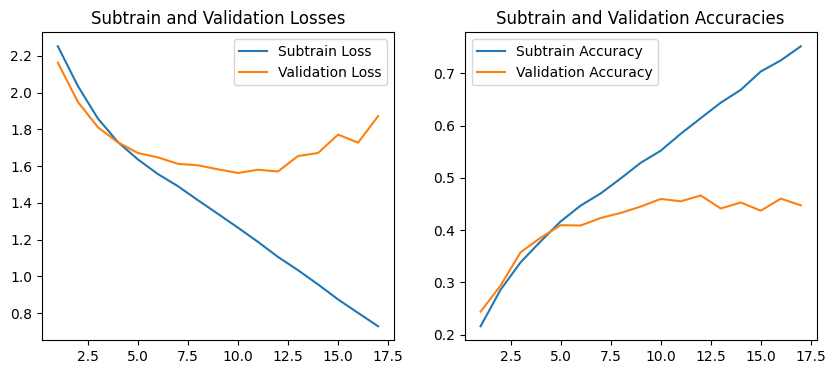

              precision    recall  f1-score   support

    airplane       0.56      0.43      0.48      1007
  automobile       0.51      0.62      0.56      1011
        bird       0.32      0.36      0.34       990
         cat       0.29      0.21      0.25      1002
        deer       0.36      0.43      0.40      1028
         dog       0.34      0.41      0.37       962
        frog       0.45      0.58      0.51       980
       horse       0.57      0.43      0.49      1065
        ship       0.60      0.54      0.57       946
       truck       0.55      0.47      0.50      1009

    accuracy                           0.45     10000
   macro avg       0.46      0.45      0.45     10000
weighted avg       0.46      0.45      0.45     10000



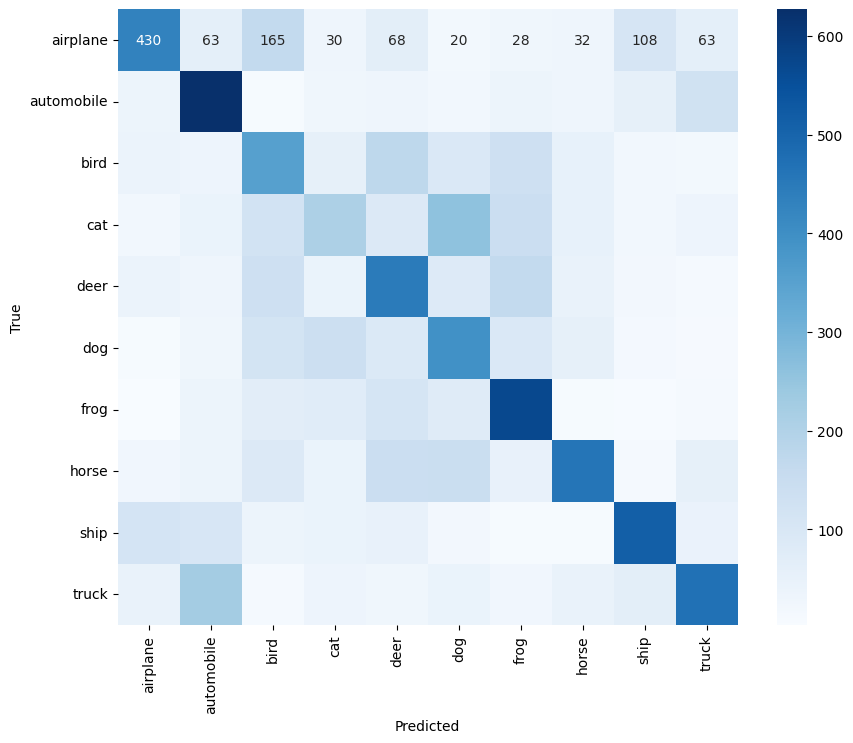

Best Epoch: 11


In [ ]:
best_epoch = experiment_and_evaluate(
    model=model1,
    subtrain_loader=subtrain_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

More layers and our network performs indeed better with 45% accuracy on validation set compared to 18%

### Let's try a different architecture

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]      12,587,008
         LeakyReLU-2                 [-1, 4096]               0
            Linear-3                 [-1, 2048]       8,390,656
         LeakyReLU-4                 [-1, 2048]               0
            Linear-5                 [-1, 1024]       2,098,176
         LeakyReLU-6                 [-1, 1024]               0
            Linear-7                   [-1, 10]          10,250
Total params: 23,086,090
Trainable params: 23,086,090
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 88.07
Estimated Total Size (MB): 88.19
----------------------------------------------------------------
Epoch 0/500, Train Loss: 2.2218, Train Acc: 0.2340, Val Loss: 2.0984, Val Acc: 0.2554
Epoch 1/500,

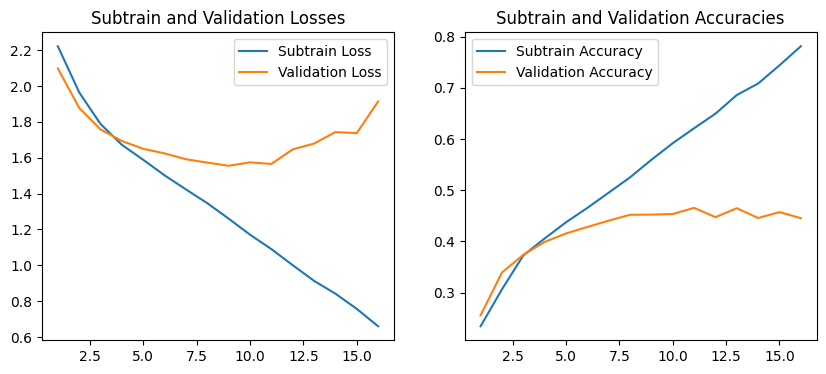

              precision    recall  f1-score   support

    airplane       0.45      0.57      0.50      1007
  automobile       0.55      0.58      0.57      1011
        bird       0.30      0.51      0.38       990
         cat       0.28      0.44      0.35      1002
        deer       0.48      0.24      0.32      1028
         dog       0.48      0.19      0.27       962
        frog       0.57      0.42      0.48       980
       horse       0.56      0.52      0.54      1065
        ship       0.52      0.63      0.57       946
       truck       0.54      0.35      0.43      1009

    accuracy                           0.45     10000
   macro avg       0.47      0.45      0.44     10000
weighted avg       0.47      0.45      0.44     10000



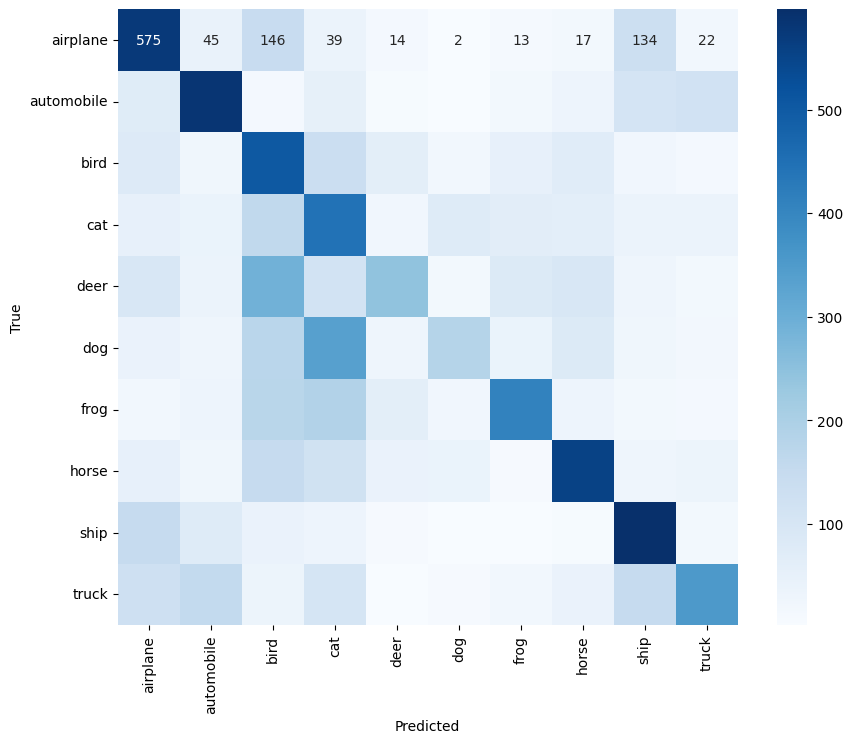

Best Epoch: 10


In [ ]:
# more hidden units [4096, 2048, 1024] so the features reduce
hidden_units = [4096, 2048, 1024] # 46
# Instantiate the model with the input size and number of classes
model1 = Classifier(input_size, num_classes, hidden_units)
# plot the model
model1.plot_model()
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Instantiate the optimizer using the learning rate from Hyperparams
optimizer = optim.SGD(model1.parameters(), lr=Hyperparams['learning_rate'], momentum=Hyperparams['momentum'])
best_epoch = experiment_and_evaluate(
    model=model1,
    subtrain_loader=subtrain_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

45% 

### Experiment 1: We are going to try a different initialization method and see if the model performs better
Currently, our model is initialized with LeCun Uniform as it is the default initialization method with Linear layers in PyTorch.
However, it was mostly designed to work with sigmoidal activation functions. However, the Kaiming initialization is designed to work well with ReLU activation functions.
Therefore applying the Kaiming initialization to the model will potentially give better results.

In [ ]:
model2 = Classifier(
    input_size,
    num_classes,
    hidden_units,
    init_method='kaiming_normal')
# plot the model
model2.plot_model()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]      12,587,008
         LeakyReLU-2                 [-1, 4096]               0
            Linear-3                 [-1, 2048]       8,390,656
         LeakyReLU-4                 [-1, 2048]               0
            Linear-5                 [-1, 1024]       2,098,176
         LeakyReLU-6                 [-1, 1024]               0
            Linear-7                   [-1, 10]          10,250
Total params: 23,086,090
Trainable params: 23,086,090
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 88.07
Estimated Total Size (MB): 88.19
----------------------------------------------------------------


In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Instantiate the optimizer using the learning rate from Hyperparams
optimizer = optim.SGD(
    model2.parameters(),
    lr=Hyperparams['learning_rate'],
    momentum=Hyperparams['momentum'])

Epoch 0/500, Train Loss: 1.8363, Train Acc: 0.3505, Val Loss: 1.7591, Val Acc: 0.3844
Epoch 1/500, Train Loss: 1.4375, Train Acc: 0.5066, Val Loss: 1.6011, Val Acc: 0.4411
Epoch 2/500, Train Loss: 1.2016, Train Acc: 0.5960, Val Loss: 1.6160, Val Acc: 0.4436
Epoch 3/500, Train Loss: 0.9993, Train Acc: 0.6758, Val Loss: 1.6160, Val Acc: 0.4432
Epoch 4/500, Train Loss: 0.8120, Train Acc: 0.7469, Val Loss: 1.6694, Val Acc: 0.4472
Epoch 5/500, Train Loss: 0.6375, Train Acc: 0.8206, Val Loss: 1.6953, Val Acc: 0.4481
Epoch 6/500, Train Loss: 0.4901, Train Acc: 0.8721, Val Loss: 1.7394, Val Acc: 0.4546
Epoch 7/500, Train Loss: 0.3571, Train Acc: 0.9163, Val Loss: 1.8334, Val Acc: 0.4529
Epoch 8/500, Train Loss: 0.2623, Train Acc: 0.9471, Val Loss: 1.9145, Val Acc: 0.4529
Epoch 9/500, Train Loss: 0.1872, Train Acc: 0.9653, Val Loss: 1.9498, Val Acc: 0.4606
Epoch 10/500, Train Loss: 0.1353, Train Acc: 0.9818, Val Loss: 2.0322, Val Acc: 0.4543
Epoch 11/500, Train Loss: 0.1042, Train Acc: 0.9868, 

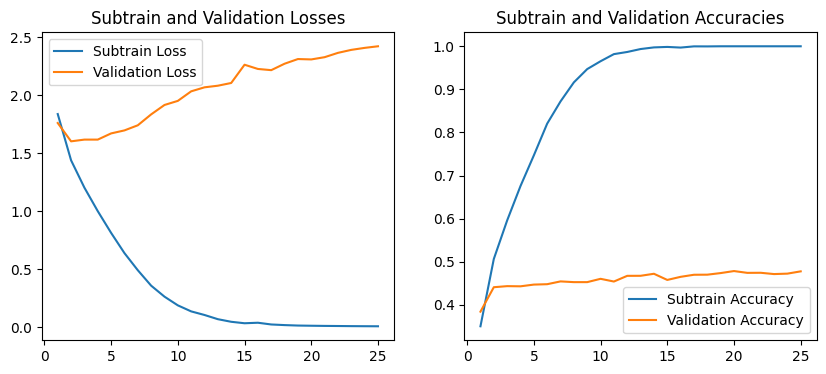

              precision    recall  f1-score   support

    airplane       0.53      0.54      0.54      1007
  automobile       0.58      0.57      0.57      1011
        bird       0.39      0.39      0.39       990
         cat       0.32      0.30      0.31      1002
        deer       0.42      0.37      0.39      1028
         dog       0.38      0.40      0.39       962
        frog       0.51      0.54      0.52       980
       horse       0.53      0.55      0.54      1065
        ship       0.57      0.61      0.59       946
       truck       0.52      0.52      0.52      1009

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     10000



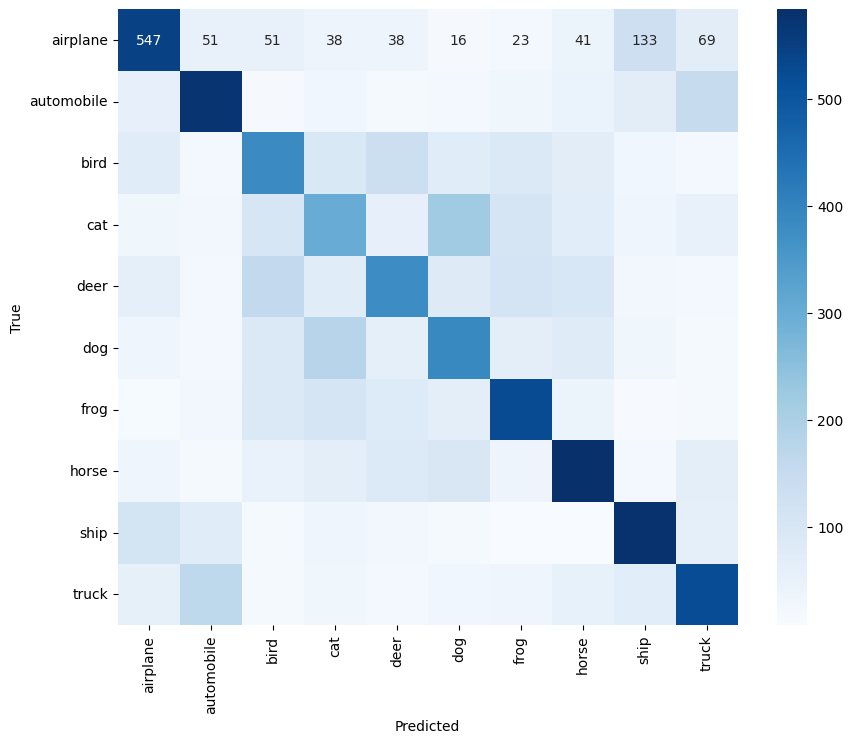

Best Epoch: 19


In [ ]:
best_epoch = experiment_and_evaluate(
    model=model2,
    subtrain_loader=subtrain_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

Ok model 2 with kaiming initialization performs even better with 48% accuracy on the validation set

### Experiment 2: We are going to try the PRELU activation
 We are using PRELU here where the activation coefficient $a$ is learned, unlike LeakyReLU.

In [ ]:
model3 = Classifier(input_size,
                    num_classes,
                    hidden_units,
                    init_method='kaiming_normal',
                    activation_function=nn.PReLU())
# plot the model
model3.plot_model()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]      12,587,008
             PReLU-2                 [-1, 4096]               1
            Linear-3                 [-1, 2048]       8,390,656
             PReLU-4                 [-1, 2048]               1
            Linear-5                 [-1, 1024]       2,098,176
             PReLU-6                 [-1, 1024]               1
            Linear-7                   [-1, 10]          10,250
Total params: 23,086,093
Trainable params: 23,086,093
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 88.07
Estimated Total Size (MB): 88.19
----------------------------------------------------------------


In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Instantiate the optimizer using the learning rate from Hyperparams
optimizer = optim.SGD(model3.parameters(), lr=Hyperparams['learning_rate'], momentum=Hyperparams['momentum'])

Epoch 0/500, Train Loss: 1.8193, Train Acc: 0.3573, Val Loss: 1.7384, Val Acc: 0.3801
Epoch 1/500, Train Loss: 1.4538, Train Acc: 0.4940, Val Loss: 1.6420, Val Acc: 0.4254
Epoch 2/500, Train Loss: 1.2352, Train Acc: 0.5841, Val Loss: 1.5811, Val Acc: 0.4483
Epoch 3/500, Train Loss: 1.0186, Train Acc: 0.6732, Val Loss: 1.6134, Val Acc: 0.4367
Epoch 4/500, Train Loss: 0.8404, Train Acc: 0.7424, Val Loss: 1.6417, Val Acc: 0.4559
Epoch 5/500, Train Loss: 0.6299, Train Acc: 0.8272, Val Loss: 1.6816, Val Acc: 0.4528
Epoch 6/500, Train Loss: 0.4577, Train Acc: 0.8895, Val Loss: 1.7694, Val Acc: 0.4423
Epoch 7/500, Train Loss: 0.3043, Train Acc: 0.9372, Val Loss: 1.8206, Val Acc: 0.4525
Epoch 8/500, Train Loss: 0.2023, Train Acc: 0.9650, Val Loss: 1.8645, Val Acc: 0.4533
Epoch 9/500, Train Loss: 0.1154, Train Acc: 0.9879, Val Loss: 2.0621, Val Acc: 0.4542
Early stopping


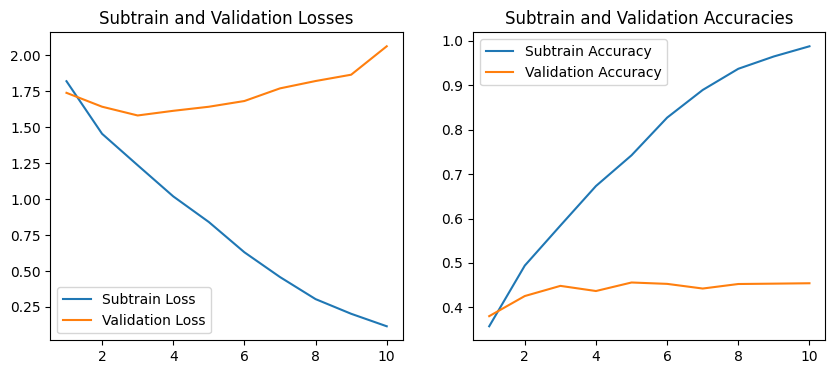

              precision    recall  f1-score   support

    airplane       0.42      0.64      0.51      1007
  automobile       0.56      0.61      0.59      1011
        bird       0.48      0.23      0.31       990
         cat       0.32      0.21      0.25      1002
        deer       0.48      0.28      0.36      1028
         dog       0.30      0.53      0.39       962
        frog       0.43      0.57      0.49       980
       horse       0.65      0.40      0.49      1065
        ship       0.55      0.63      0.59       946
       truck       0.53      0.45      0.49      1009

    accuracy                           0.45     10000
   macro avg       0.47      0.46      0.45     10000
weighted avg       0.47      0.45      0.45     10000



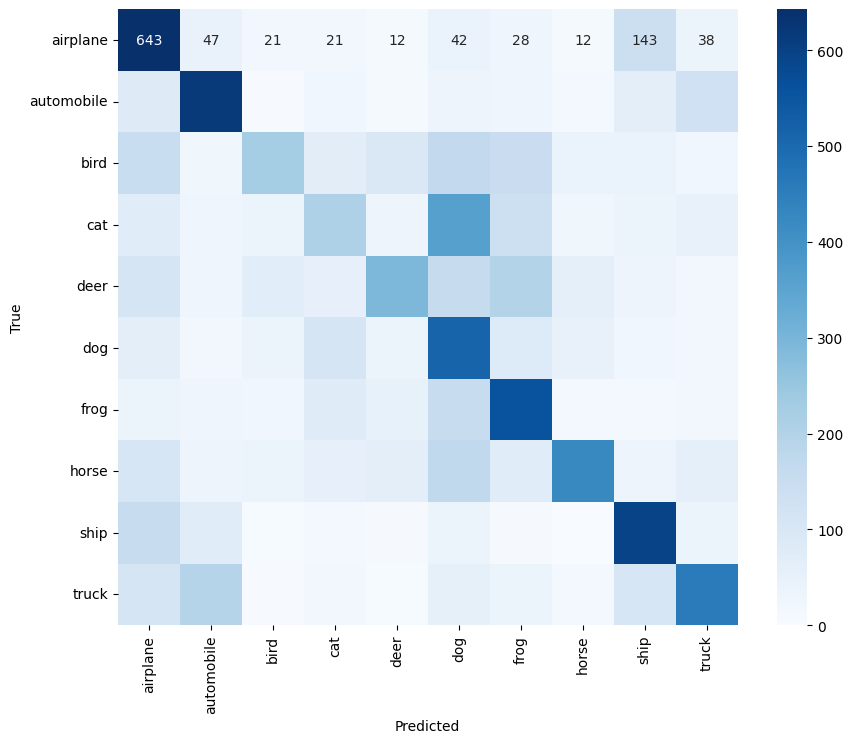

Best Epoch: 4


In [ ]:
best_epoch = experiment_and_evaluate(
    model=model3,
    subtrain_loader=subtrain_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

PReLU activation reaches 45% (in older notebook i found 47%) on the validation set as well so it's not conclusively better than LeakyReLU in this case. However, 
not having to find the best hyperparameter for LeakyReLU is a good way to get the best performance.

### Experiment 3: We are going to try the focal loss function which is known to be an error aware loss
 We are using the focal loss here because it is known to be an error aware loss which can help the model focus more on the samples it is having a hard time with.

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha: float = 1., gamma: float = 2., reduction: str = 'mean'):
        """
        Initializes the Focal Loss module.
        
        Parameters:
            alpha (float): Weighting factor for the rare class. Default is 1.
            gamma (float): Focusing parameter to down-weight the easy examples. Default is 2.
            reduction (str): Specifies the reduction to apply to the output: 
                             'none' | 'mean' | 'sum'. 'none': no reduction will 
                             be applied, 'mean': the sum of the output will be 
                             divided by the number of elements in the output, 
                             'sum': the output will be summed. Default is 'mean'.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Computes the focal loss.
        
        Parameters:
            inputs (torch.Tensor): The input logits.
            targets (torch.Tensor): The ground-truth labels.
            
        Returns:
            torch.Tensor: The computed focal loss.
        """
        # Get the log softmax of the inputs
        log_softmax = F.log_softmax(inputs, dim=1)

        # Select the log softmax value at each true label index
        selected_log_probs = log_softmax.gather(1, targets.unsqueeze(1))
        selected_log_probs = selected_log_probs.squeeze(1)

        # Calculate the focal loss
        loss = -self.alpha * (1 - torch.exp(selected_log_probs)) ** self.gamma * selected_log_probs

        # Apply reduction
        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss


In [ ]:
model4 = Classifier(input_size,
                    num_classes,
                    hidden_units,
                    init_method='kaiming_normal',
                    activation_function=nn.PReLU())
# plot the model
model4.plot_model()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]      12,587,008
             PReLU-2                 [-1, 4096]               1
            Linear-3                 [-1, 2048]       8,390,656
             PReLU-4                 [-1, 2048]               1
            Linear-5                 [-1, 1024]       2,098,176
             PReLU-6                 [-1, 1024]               1
            Linear-7                   [-1, 10]          10,250
Total params: 23,086,093
Trainable params: 23,086,093
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 88.07
Estimated Total Size (MB): 88.19
----------------------------------------------------------------


In [ ]:
# Define the loss function
criterion = FocalLoss(alpha=1, gamma=2)  # using the default params 
# Instantiate the optimizer using the learning rate from Hyperparams
optimizer = optim.SGD(model4.parameters(), lr=Hyperparams['learning_rate'], momentum=Hyperparams['momentum'])

Epoch 0/500, Train Loss: 1.3439, Train Acc: 0.3570, Val Loss: 1.1899, Val Acc: 0.4106
Epoch 1/500, Train Loss: 0.9478, Train Acc: 0.5115, Val Loss: 1.1435, Val Acc: 0.4269
Epoch 2/500, Train Loss: 0.7391, Train Acc: 0.6229, Val Loss: 1.1595, Val Acc: 0.4251
Epoch 3/500, Train Loss: 0.5595, Train Acc: 0.7071, Val Loss: 1.1492, Val Acc: 0.4367
Epoch 4/500, Train Loss: 0.3885, Train Acc: 0.7977, Val Loss: 1.1711, Val Acc: 0.4419
Epoch 5/500, Train Loss: 0.2543, Train Acc: 0.8789, Val Loss: 1.1625, Val Acc: 0.4521
Epoch 6/500, Train Loss: 0.1572, Train Acc: 0.9275, Val Loss: 1.2190, Val Acc: 0.4420
Epoch 7/500, Train Loss: 0.0911, Train Acc: 0.9640, Val Loss: 1.2711, Val Acc: 0.4522
Epoch 8/500, Train Loss: 0.0544, Train Acc: 0.9828, Val Loss: 1.2518, Val Acc: 0.4568
Epoch 9/500, Train Loss: 0.0299, Train Acc: 0.9925, Val Loss: 1.2839, Val Acc: 0.4546
Epoch 10/500, Train Loss: 0.0163, Train Acc: 0.9977, Val Loss: 1.2957, Val Acc: 0.4532
Epoch 11/500, Train Loss: 0.0110, Train Acc: 0.9988, 

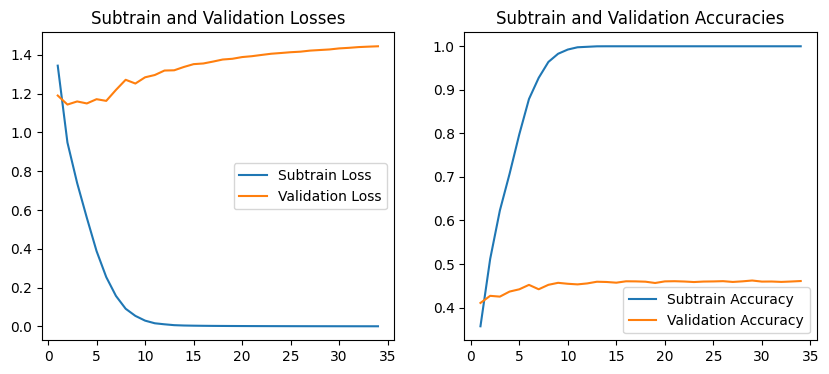

              precision    recall  f1-score   support

    airplane       0.51      0.55      0.53      1007
  automobile       0.57      0.56      0.57      1011
        bird       0.37      0.39      0.38       990
         cat       0.30      0.31      0.31      1002
        deer       0.38      0.38      0.38      1028
         dog       0.34      0.33      0.33       962
        frog       0.49      0.48      0.48       980
       horse       0.56      0.49      0.52      1065
        ship       0.57      0.61      0.59       946
       truck       0.52      0.51      0.51      1009

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.46     10000
weighted avg       0.46      0.46      0.46     10000



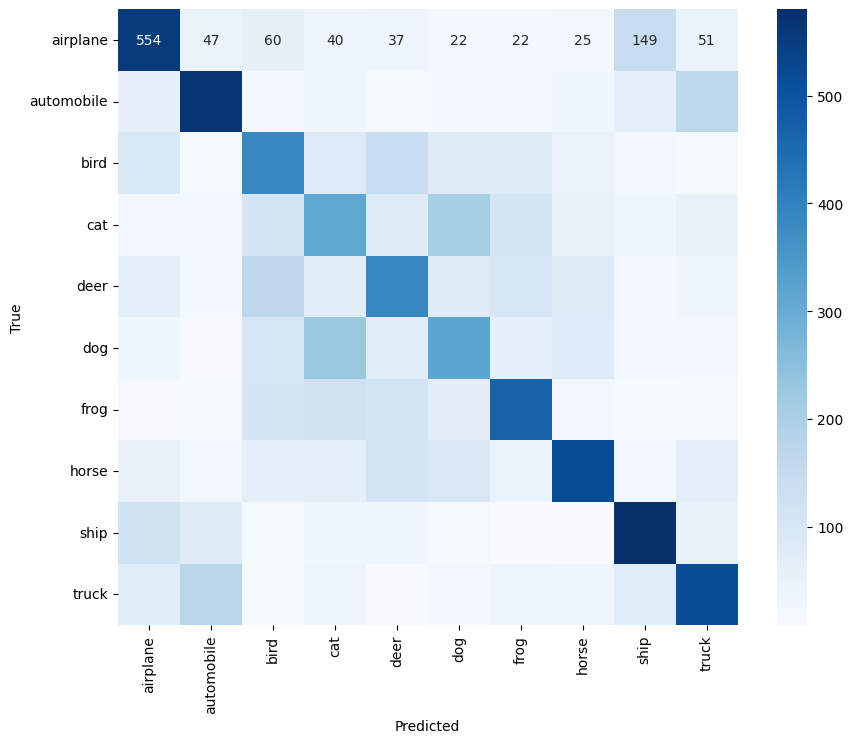

Best Epoch: 28


In [ ]:
best_epoch = experiment_and_evaluate(
    model=model4,
    subtrain_loader=subtrain_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

In this case, focal loss is not doing better than Cross-Entropy loss. This might be because the classes are very balanced in this dataset.
Therefore, we will continue to use the Cross-Entropy loss.

### Experiment 4: Compare Batch Normalization and Layer Normalization performance
 We are going to compare the performance of Batch Normalization and Layer Normalization. 

In [ ]:
# Batch Normalization
model5 = Classifier(input_size,
                    num_classes,
                    hidden_units,
                    init_method='kaiming_normal',
                    activation_function=nn.PReLU(),
                    normalization='batch')
# plot the model
model5.plot_model()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]      12,587,008
       BatchNorm1d-2                 [-1, 4096]           8,192
             PReLU-3                 [-1, 4096]               1
            Linear-4                 [-1, 2048]       8,390,656
       BatchNorm1d-5                 [-1, 2048]           4,096
             PReLU-6                 [-1, 2048]               1
            Linear-7                 [-1, 1024]       2,098,176
       BatchNorm1d-8                 [-1, 1024]           2,048
             PReLU-9                 [-1, 1024]               1
           Linear-10                   [-1, 10]          10,250
Total params: 23,100,429
Trainable params: 23,100,429
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.16
Params size (MB): 88.12
Esti

In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Instantiate the optimizer using the learning rate from Hyperparams
optimizer = optim.SGD(model5.parameters(), lr=Hyperparams['learning_rate'], momentum=Hyperparams['momentum'])

Epoch 0/500, Train Loss: 1.7967, Train Acc: 0.3758, Val Loss: 1.6386, Val Acc: 0.4343
Epoch 1/500, Train Loss: 1.1174, Train Acc: 0.6315, Val Loss: 1.6110, Val Acc: 0.4476
Epoch 2/500, Train Loss: 0.6972, Train Acc: 0.8144, Val Loss: 1.6200, Val Acc: 0.4533
Epoch 3/500, Train Loss: 0.3829, Train Acc: 0.9224, Val Loss: 1.6547, Val Acc: 0.4490
Epoch 4/500, Train Loss: 0.2026, Train Acc: 0.9713, Val Loss: 1.7109, Val Acc: 0.4488
Epoch 5/500, Train Loss: 0.1151, Train Acc: 0.9870, Val Loss: 1.7000, Val Acc: 0.4626
Epoch 6/500, Train Loss: 0.0664, Train Acc: 0.9949, Val Loss: 1.7147, Val Acc: 0.4592
Epoch 7/500, Train Loss: 0.0478, Train Acc: 0.9977, Val Loss: 1.7730, Val Acc: 0.4635
Epoch 8/500, Train Loss: 0.0353, Train Acc: 0.9985, Val Loss: 1.7727, Val Acc: 0.4615
Epoch 9/500, Train Loss: 0.0363, Train Acc: 0.9981, Val Loss: 1.8016, Val Acc: 0.4656
Epoch 10/500, Train Loss: 0.0278, Train Acc: 0.9989, Val Loss: 1.8280, Val Acc: 0.4658
Epoch 11/500, Train Loss: 0.0190, Train Acc: 0.9994, 

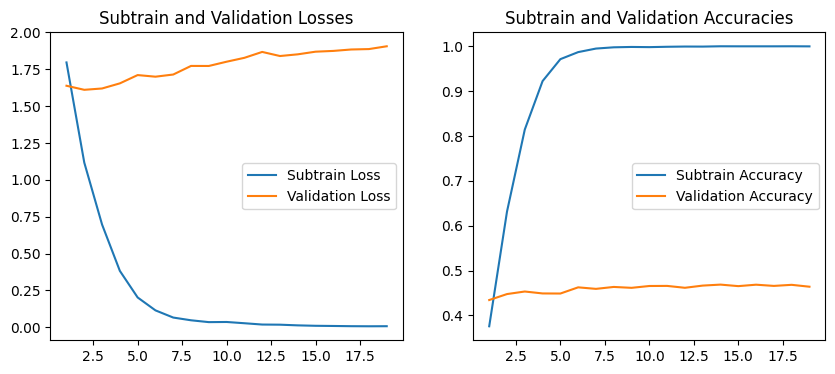

              precision    recall  f1-score   support

    airplane       0.55      0.49      0.52      1007
  automobile       0.58      0.56      0.57      1011
        bird       0.36      0.41      0.38       990
         cat       0.29      0.33      0.31      1002
        deer       0.42      0.37      0.39      1028
         dog       0.36      0.36      0.36       962
        frog       0.51      0.46      0.48       980
       horse       0.50      0.50      0.50      1065
        ship       0.60      0.61      0.61       946
       truck       0.50      0.55      0.53      1009

    accuracy                           0.46     10000
   macro avg       0.47      0.46      0.47     10000
weighted avg       0.47      0.46      0.47     10000



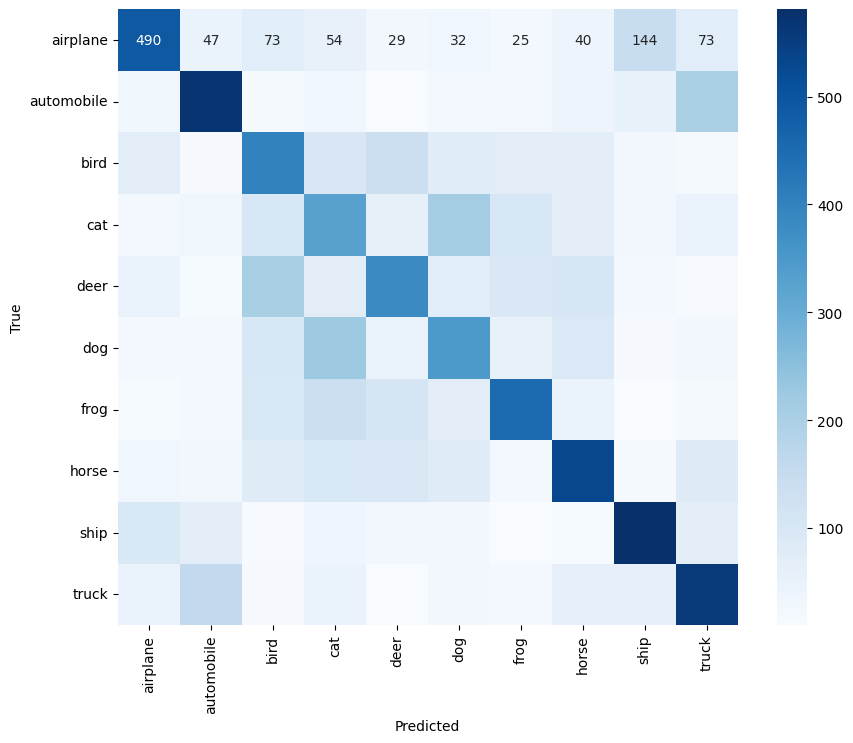

Best Epoch: 13


In [ ]:
best_epoch = experiment_and_evaluate(
    model=model5,
    subtrain_loader=subtrain_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

Add Batch Normalization performs worse (46%) than not adding Batch Normalization

In [ ]:
# Layer Normalization
model6 = Classifier(input_size,
                    num_classes,
                    hidden_units,
                    init_method='kaiming_normal',
                    activation_function=nn.PReLU(),
                    normalization='layer')
# plot the model
model6.plot_model()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]      12,587,008
         LayerNorm-2                 [-1, 4096]           8,192
             PReLU-3                 [-1, 4096]               1
            Linear-4                 [-1, 2048]       8,390,656
         LayerNorm-5                 [-1, 2048]           4,096
             PReLU-6                 [-1, 2048]               1
            Linear-7                 [-1, 1024]       2,098,176
         LayerNorm-8                 [-1, 1024]           2,048
             PReLU-9                 [-1, 1024]               1
           Linear-10                   [-1, 10]          10,250
Total params: 23,100,429
Trainable params: 23,100,429
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.16
Params size (MB): 88.12
Esti

In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Instantiate the optimizer using the learning rate from Hyperparams
optimizer = optim.SGD(model6.parameters(), lr=Hyperparams['learning_rate'], momentum=Hyperparams['momentum'])

Epoch 0/500, Train Loss: 1.8525, Train Acc: 0.3588, Val Loss: 1.6756, Val Acc: 0.4108
Epoch 1/500, Train Loss: 1.4025, Train Acc: 0.5080, Val Loss: 1.6498, Val Acc: 0.4246
Epoch 2/500, Train Loss: 1.0704, Train Acc: 0.6418, Val Loss: 1.6461, Val Acc: 0.4333
Epoch 3/500, Train Loss: 0.7513, Train Acc: 0.7657, Val Loss: 1.7256, Val Acc: 0.4384
Epoch 4/500, Train Loss: 0.4520, Train Acc: 0.8826, Val Loss: 1.7515, Val Acc: 0.4451
Epoch 5/500, Train Loss: 0.2487, Train Acc: 0.9420, Val Loss: 1.8457, Val Acc: 0.4382
Epoch 6/500, Train Loss: 0.1446, Train Acc: 0.9718, Val Loss: 1.8467, Val Acc: 0.4453
Epoch 7/500, Train Loss: 0.0777, Train Acc: 0.9879, Val Loss: 1.8640, Val Acc: 0.4571
Epoch 8/500, Train Loss: 0.0372, Train Acc: 0.9957, Val Loss: 1.9559, Val Acc: 0.4456
Epoch 9/500, Train Loss: 0.0186, Train Acc: 0.9987, Val Loss: 1.9392, Val Acc: 0.4646
Epoch 10/500, Train Loss: 0.0097, Train Acc: 0.9997, Val Loss: 1.9315, Val Acc: 0.4721
Epoch 11/500, Train Loss: 0.0065, Train Acc: 0.9999, 

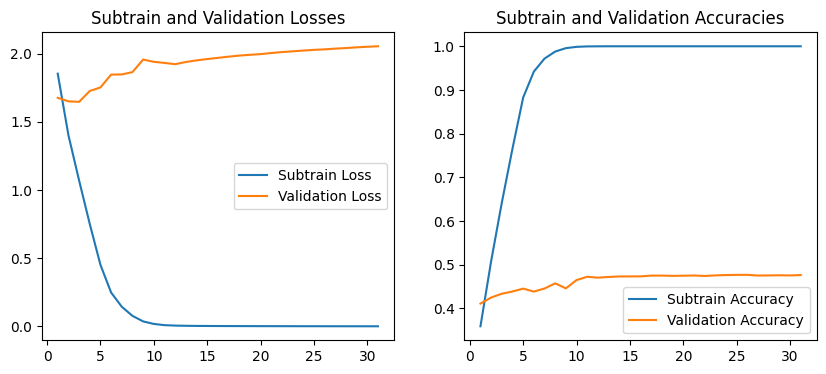

              precision    recall  f1-score   support

    airplane       0.54      0.55      0.54      1007
  automobile       0.55      0.59      0.57      1011
        bird       0.41      0.36      0.39       990
         cat       0.32      0.31      0.31      1002
        deer       0.41      0.39      0.40      1028
         dog       0.36      0.35      0.35       962
        frog       0.51      0.52      0.51       980
       horse       0.53      0.52      0.53      1065
        ship       0.58      0.64      0.61       946
       truck       0.51      0.53      0.52      1009

    accuracy                           0.48     10000
   macro avg       0.47      0.48      0.47     10000
weighted avg       0.47      0.48      0.47     10000



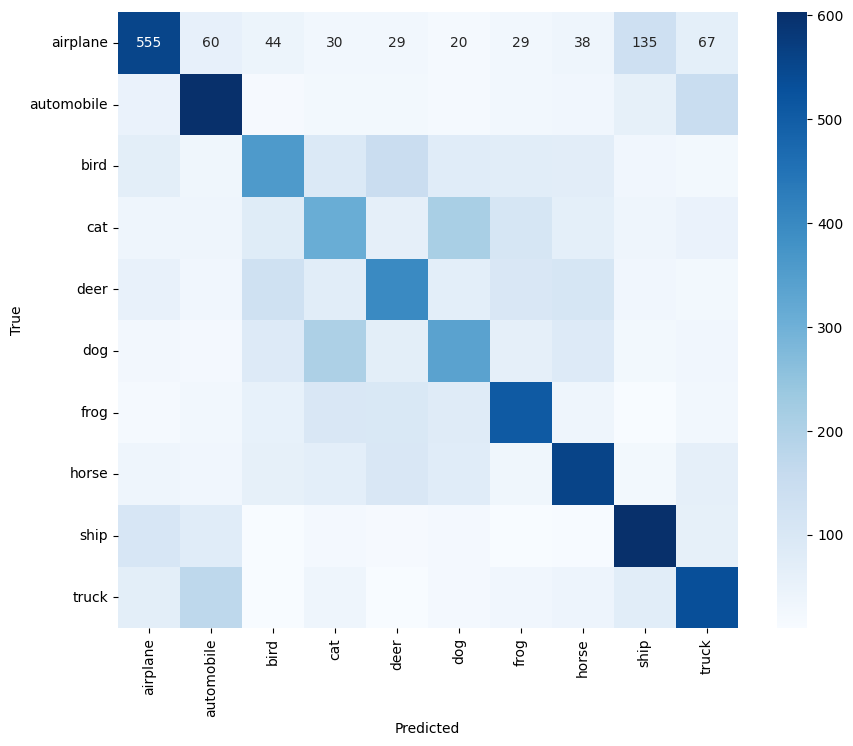

Best Epoch: 25


In [ ]:
best_epoch = experiment_and_evaluate(
    model=model6,
    subtrain_loader=subtrain_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

At 48% validation accuracy, Layer Normalization performs better than Batch Normalization. We will continue with Layer Normalization then.

### Experiment 5: We will be experimenting with regularization here

#### Experiment 5a: Weight decay. It will help reduce overfitting in the model.

In [ ]:
# add weight decay
Hyperparams['weight_decay'] = 3e-8

In [ ]:
model7 = Classifier(input_size,
                    num_classes,
                    hidden_units,
                    init_method='kaiming_normal',
                    activation_function=nn.PReLU(),
                    normalization='layer')
# plot the model
model7.plot_model()
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Instantiate the optimizer using the learning rate from Hyperparams
optimizer = optim.SGD(
    model7.parameters(),
    lr=Hyperparams['learning_rate'],
    momentum=Hyperparams['momentum'],
    weight_decay=Hyperparams['weight_decay'])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]      12,587,008
         LayerNorm-2                 [-1, 4096]           8,192
             PReLU-3                 [-1, 4096]               1
            Linear-4                 [-1, 2048]       8,390,656
         LayerNorm-5                 [-1, 2048]           4,096
             PReLU-6                 [-1, 2048]               1
            Linear-7                 [-1, 1024]       2,098,176
         LayerNorm-8                 [-1, 1024]           2,048
             PReLU-9                 [-1, 1024]               1
           Linear-10                   [-1, 10]          10,250
Total params: 23,100,429
Trainable params: 23,100,429
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.16
Params size (MB): 88.12
Esti

Epoch 0/500, Train Loss: 1.8388, Train Acc: 0.3565, Val Loss: 1.7171, Val Acc: 0.3897
Epoch 1/500, Train Loss: 1.4023, Train Acc: 0.5089, Val Loss: 1.6571, Val Acc: 0.4123
Epoch 2/500, Train Loss: 1.1037, Train Acc: 0.6256, Val Loss: 1.7301, Val Acc: 0.4099
Epoch 3/500, Train Loss: 0.7840, Train Acc: 0.7486, Val Loss: 1.7890, Val Acc: 0.4175
Epoch 4/500, Train Loss: 0.4861, Train Acc: 0.8645, Val Loss: 1.8365, Val Acc: 0.4274
Epoch 5/500, Train Loss: 0.2524, Train Acc: 0.9440, Val Loss: 1.8029, Val Acc: 0.4448
Epoch 6/500, Train Loss: 0.1196, Train Acc: 0.9791, Val Loss: 1.8879, Val Acc: 0.4476
Epoch 7/500, Train Loss: 0.0723, Train Acc: 0.9887, Val Loss: 1.9287, Val Acc: 0.4549
Epoch 8/500, Train Loss: 0.0485, Train Acc: 0.9921, Val Loss: 1.8710, Val Acc: 0.4619
Epoch 9/500, Train Loss: 0.0219, Train Acc: 0.9981, Val Loss: 1.9122, Val Acc: 0.4678
Epoch 10/500, Train Loss: 0.0117, Train Acc: 0.9989, Val Loss: 1.9310, Val Acc: 0.4676
Epoch 11/500, Train Loss: 0.0074, Train Acc: 0.9999, 

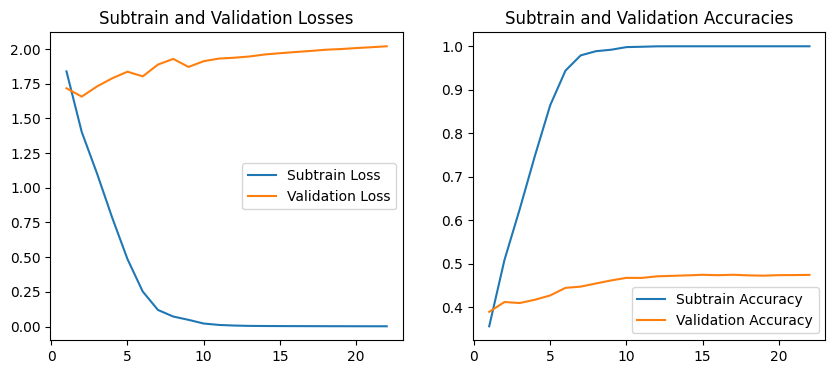

              precision    recall  f1-score   support

    airplane       0.53      0.54      0.53      1007
  automobile       0.55      0.60      0.58      1011
        bird       0.39      0.36      0.37       990
         cat       0.32      0.31      0.32      1002
        deer       0.41      0.39      0.40      1028
         dog       0.38      0.37      0.37       962
        frog       0.50      0.50      0.50       980
       horse       0.54      0.53      0.53      1065
        ship       0.58      0.62      0.60       946
       truck       0.51      0.52      0.52      1009

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.47     10000
weighted avg       0.47      0.47      0.47     10000



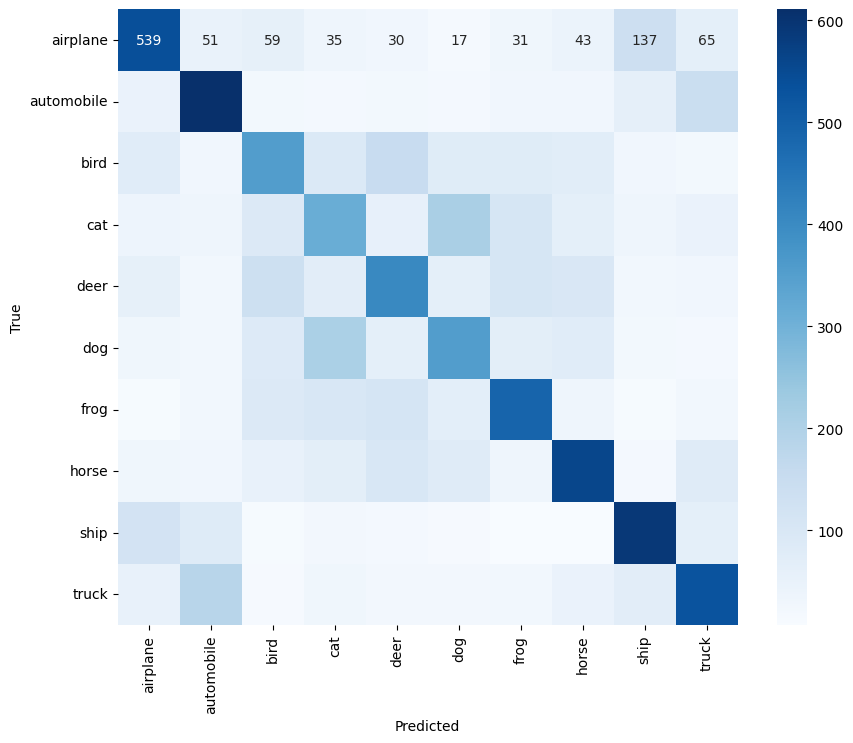

Best Epoch: 16


In [ ]:
best_epoch = experiment_and_evaluate(
    model=model7,
    subtrain_loader=subtrain_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

At 47% weight decay is not too bad. However, Early Stopping almost always does a better job at avoiding overfitting. Weight decay might be useful for
the final training run without early stopping. I am also noticing a pattern of overfitting when it comes to MLP on Cifar10. The subtraining accuracy is 100% while validation is 47% at best so far.

#### Experiment 5b: Dropout 
Dropout is another successful regularization technique. It helps to prevent overfitting in the model. We are experimenting with dropout here.

In [ ]:
# dropout
model8 = Classifier(input_size,
                    num_classes,
                    hidden_units,
                    init_method='kaiming_normal',
                    activation_function=nn.PReLU(),
                    normalization='layer',
                    dropout=0.2)
# plot the model
model8.plot_model()
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Instantiate the optimizer using the learning rate from Hyperparams
optimizer = optim.SGD(
    model8.parameters(),
    lr=Hyperparams['learning_rate'],
    momentum=Hyperparams['momentum'],
    # weight_decay=Hyperparams['weight_decay'],
)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]      12,587,008
         LayerNorm-2                 [-1, 4096]           8,192
             PReLU-3                 [-1, 4096]               1
           Dropout-4                 [-1, 4096]               0
            Linear-5                 [-1, 2048]       8,390,656
         LayerNorm-6                 [-1, 2048]           4,096
             PReLU-7                 [-1, 2048]               1
           Dropout-8                 [-1, 2048]               0
            Linear-9                 [-1, 1024]       2,098,176
        LayerNorm-10                 [-1, 1024]           2,048
            PReLU-11                 [-1, 1024]               1
          Dropout-12                 [-1, 1024]               0
           Linear-13                   [-1, 10]          10,250
Total params: 23,100,429
Trainable para

Epoch 0/500, Train Loss: 1.9997, Train Acc: 0.3092, Val Loss: 1.7011, Val Acc: 0.3957
Epoch 1/500, Train Loss: 1.6670, Train Acc: 0.4131, Val Loss: 1.6903, Val Acc: 0.4161
Epoch 2/500, Train Loss: 1.5293, Train Acc: 0.4660, Val Loss: 1.6521, Val Acc: 0.4307
Epoch 3/500, Train Loss: 1.4213, Train Acc: 0.4944, Val Loss: 1.6912, Val Acc: 0.4399
Epoch 4/500, Train Loss: 1.3179, Train Acc: 0.5353, Val Loss: 1.6572, Val Acc: 0.4436
Epoch 5/500, Train Loss: 1.1978, Train Acc: 0.5724, Val Loss: 1.7496, Val Acc: 0.4408
Epoch 6/500, Train Loss: 1.1123, Train Acc: 0.6106, Val Loss: 1.7002, Val Acc: 0.4660
Epoch 7/500, Train Loss: 1.0325, Train Acc: 0.6372, Val Loss: 1.7467, Val Acc: 0.4659
Epoch 8/500, Train Loss: 0.9206, Train Acc: 0.6780, Val Loss: 1.8181, Val Acc: 0.4618
Epoch 9/500, Train Loss: 0.8550, Train Acc: 0.6973, Val Loss: 1.7929, Val Acc: 0.4642
Epoch 10/500, Train Loss: 0.7762, Train Acc: 0.7326, Val Loss: 1.8759, Val Acc: 0.4578
Epoch 11/500, Train Loss: 0.6939, Train Acc: 0.7564, 

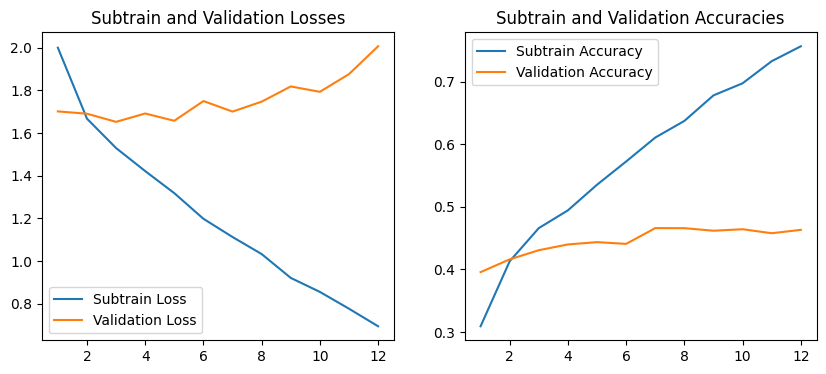

              precision    recall  f1-score   support

    airplane       0.53      0.54      0.53      1007
  automobile       0.60      0.56      0.58      1011
        bird       0.40      0.31      0.35       990
         cat       0.34      0.23      0.27      1002
        deer       0.35      0.49      0.41      1028
         dog       0.38      0.40      0.39       962
        frog       0.53      0.37      0.43       980
       horse       0.46      0.62      0.53      1065
        ship       0.51      0.70      0.59       946
       truck       0.57      0.41      0.48      1009

    accuracy                           0.46     10000
   macro avg       0.47      0.46      0.46     10000
weighted avg       0.47      0.46      0.46     10000



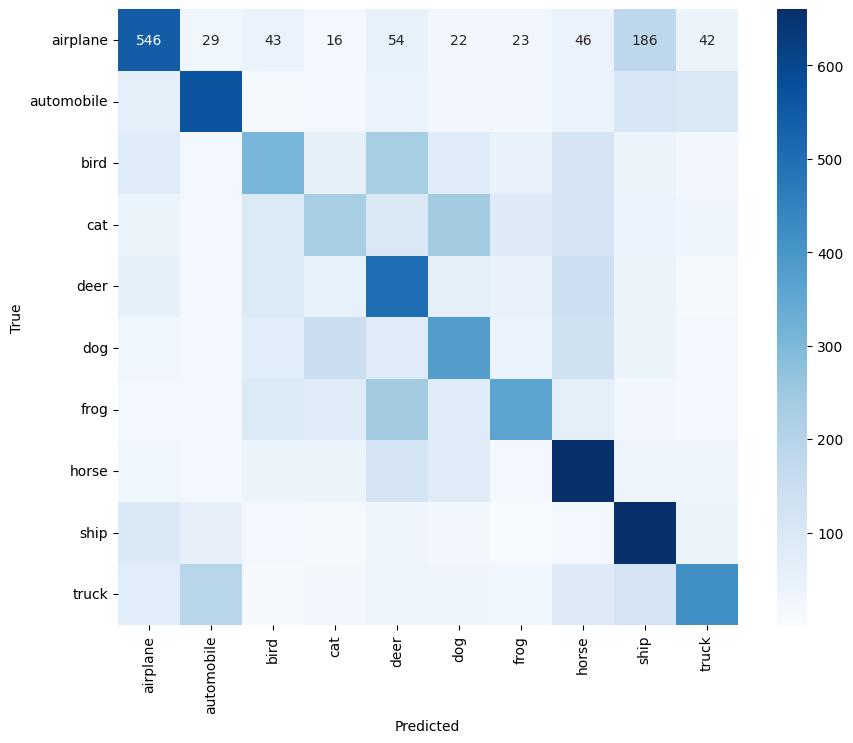

Best Epoch: 6


In [ ]:
best_epoch = experiment_and_evaluate(
    model=model8,
    subtrain_loader=subtrain_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

At 46%, Dropout is offering an ok performance for our model.

#### Experiment 5c: Data augmentations
We are going to explore using data augmentations to train our model. The augmentations we are applying are fairly basic but will 
hopefully help the model be invariant to non-useful features in the image.

In [ ]:
# Define the transform with augmentations
augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(32),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Apply augmentations to the subtraining set
aug_subtrain_set = OneHotEncodedCIFAR10(
    datasets.CIFAR10(root='./data', train=True, download=True, transform=augmented_transform))
aug_subtrain_set, aug_val_set, _ = data.random_split(aug_subtrain_set, [subtrain_len, validation_len, test_len])

# Apply augmentations to the training set
aug_training_set = data.ConcatDataset([aug_subtrain_set, aug_val_set])  # Reuse val_set from above

# Create augmented DataLoaders
aug_subtrain_loader = data.DataLoader(aug_subtrain_set, batch_size=Hyperparams['batch_size'], shuffle=True)
aug_train_loader = data.DataLoader(aug_training_set, batch_size=Hyperparams['batch_size'], shuffle=True)


Files already downloaded and verified


In [ ]:
# dropout
model9 = Classifier(input_size,
                    num_classes,
                    hidden_units,
                    init_method='kaiming_normal',
                    activation_function=nn.PReLU(),
                    normalization='layer',
                    dropout=0.2)
# plot the model
model9.plot_model()
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Instantiate the optimizer using the learning rate from Hyperparams
optimizer = optim.SGD(
    model9.parameters(),
    lr=Hyperparams['learning_rate'],
    momentum=Hyperparams['momentum'],
    # weight_decay=Hyperparams['weight_decay'],
)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]      12,587,008
         LayerNorm-2                 [-1, 4096]           8,192
             PReLU-3                 [-1, 4096]               1
           Dropout-4                 [-1, 4096]               0
            Linear-5                 [-1, 2048]       8,390,656
         LayerNorm-6                 [-1, 2048]           4,096
             PReLU-7                 [-1, 2048]               1
           Dropout-8                 [-1, 2048]               0
            Linear-9                 [-1, 1024]       2,098,176
        LayerNorm-10                 [-1, 1024]           2,048
            PReLU-11                 [-1, 1024]               1
          Dropout-12                 [-1, 1024]               0
           Linear-13                   [-1, 10]          10,250
Total params: 23,100,429
Trainable para

Epoch 0/500, Train Loss: 2.2340, Train Acc: 0.2201, Val Loss: 1.8604, Val Acc: 0.3337
Epoch 1/500, Train Loss: 2.0733, Train Acc: 0.2515, Val Loss: 1.8302, Val Acc: 0.3405
Epoch 2/500, Train Loss: 2.0198, Train Acc: 0.2721, Val Loss: 1.8196, Val Acc: 0.3350
Epoch 3/500, Train Loss: 1.9913, Train Acc: 0.2782, Val Loss: 1.7646, Val Acc: 0.3756
Epoch 4/500, Train Loss: 1.9701, Train Acc: 0.2876, Val Loss: 1.7388, Val Acc: 0.3701
Epoch 5/500, Train Loss: 1.9622, Train Acc: 0.2869, Val Loss: 1.6979, Val Acc: 0.3897
Epoch 6/500, Train Loss: 1.9440, Train Acc: 0.2971, Val Loss: 1.7142, Val Acc: 0.3939
Epoch 7/500, Train Loss: 1.9194, Train Acc: 0.2988, Val Loss: 1.6524, Val Acc: 0.4078
Epoch 8/500, Train Loss: 1.9022, Train Acc: 0.3111, Val Loss: 1.6366, Val Acc: 0.4158
Epoch 9/500, Train Loss: 1.8947, Train Acc: 0.3172, Val Loss: 1.6561, Val Acc: 0.4077
Epoch 10/500, Train Loss: 1.8957, Train Acc: 0.3118, Val Loss: 1.6495, Val Acc: 0.4102
Epoch 11/500, Train Loss: 1.8821, Train Acc: 0.3189, 

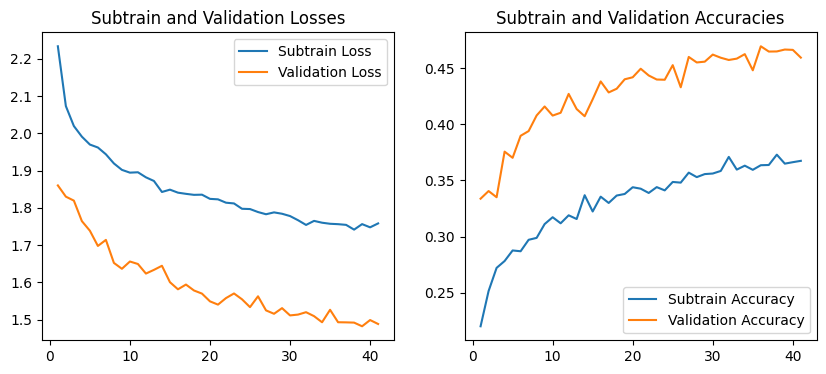

              precision    recall  f1-score   support

    airplane       0.48      0.57      0.52      1007
  automobile       0.62      0.54      0.57      1011
        bird       0.50      0.18      0.26       990
         cat       0.39      0.07      0.12      1002
        deer       0.47      0.32      0.38      1028
         dog       0.31      0.54      0.39       962
        frog       0.40      0.65      0.50       980
       horse       0.54      0.54      0.54      1065
        ship       0.51      0.73      0.60       946
       truck       0.47      0.47      0.47      1009

    accuracy                           0.46     10000
   macro avg       0.47      0.46      0.44     10000
weighted avg       0.47      0.46      0.44     10000



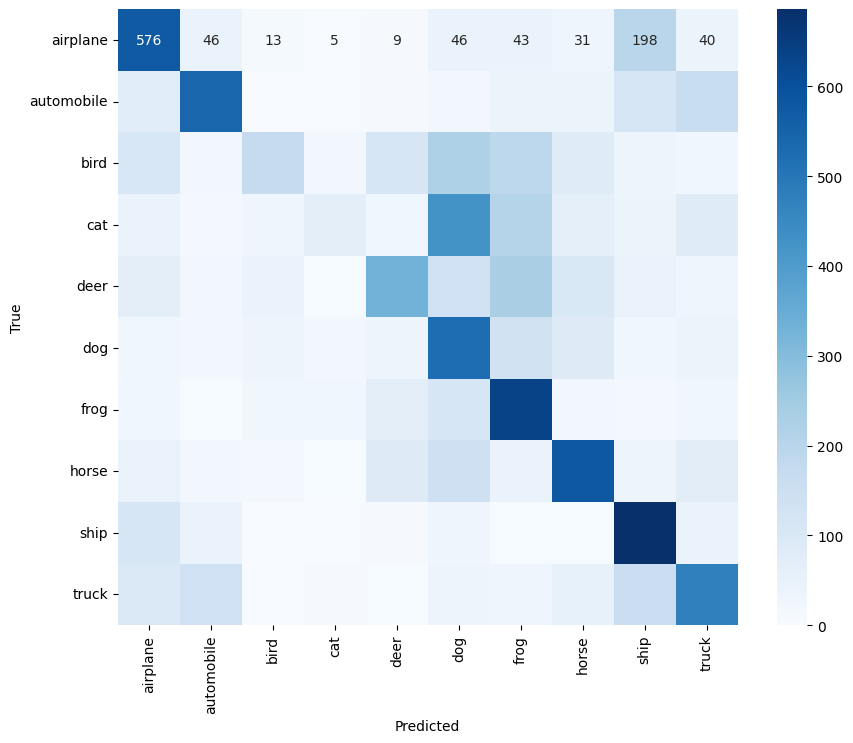

Best Epoch: 35


In [ ]:
best_epoch = experiment_and_evaluate(
    model=model9,
    subtrain_loader=aug_subtrain_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

At 48%, it seems that data augmentations do improve the performance of our model.

Let's try adam optimizer


Epoch 0/500, Train Loss: 2.5275, Train Acc: 0.1725, Val Loss: 2.0818, Val Acc: 0.2382
Epoch 1/500, Train Loss: 2.1176, Train Acc: 0.2207, Val Loss: 1.9580, Val Acc: 0.2827
Epoch 2/500, Train Loss: 2.0361, Train Acc: 0.2509, Val Loss: 1.8699, Val Acc: 0.3269
Epoch 3/500, Train Loss: 1.9733, Train Acc: 0.2706, Val Loss: 1.8192, Val Acc: 0.3474
Epoch 4/500, Train Loss: 1.9501, Train Acc: 0.2805, Val Loss: 1.8010, Val Acc: 0.3385
Epoch 5/500, Train Loss: 1.9363, Train Acc: 0.2872, Val Loss: 1.7540, Val Acc: 0.3705
Epoch 6/500, Train Loss: 1.9042, Train Acc: 0.3067, Val Loss: 1.7263, Val Acc: 0.3798
Epoch 7/500, Train Loss: 1.8886, Train Acc: 0.3168, Val Loss: 1.7032, Val Acc: 0.3940
Epoch 8/500, Train Loss: 1.8812, Train Acc: 0.3157, Val Loss: 1.6875, Val Acc: 0.3893
Epoch 9/500, Train Loss: 1.8649, Train Acc: 0.3205, Val Loss: 1.6917, Val Acc: 0.3957
Epoch 10/500, Train Loss: 1.8491, Train Acc: 0.3337, Val Loss: 1.6696, Val Acc: 0.4028
Epoch 11/500, Train Loss: 1.8417, Train Acc: 0.3338, 

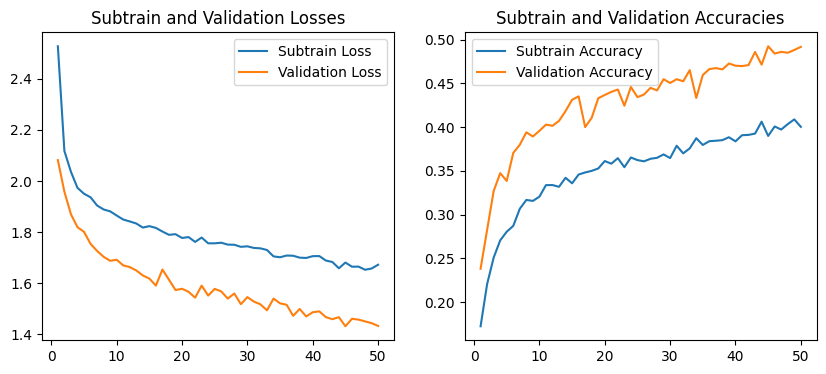

              precision    recall  f1-score   support

    airplane       0.57      0.55      0.56      1007
  automobile       0.60      0.63      0.61      1011
        bird       0.37      0.37      0.37       990
         cat       0.38      0.24      0.29      1002
        deer       0.51      0.32      0.39      1028
         dog       0.39      0.39      0.39       962
        frog       0.43      0.63      0.51       980
       horse       0.53      0.58      0.55      1065
        ship       0.60      0.65      0.62       946
       truck       0.52      0.55      0.53      1009

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.48     10000
weighted avg       0.49      0.49      0.48     10000



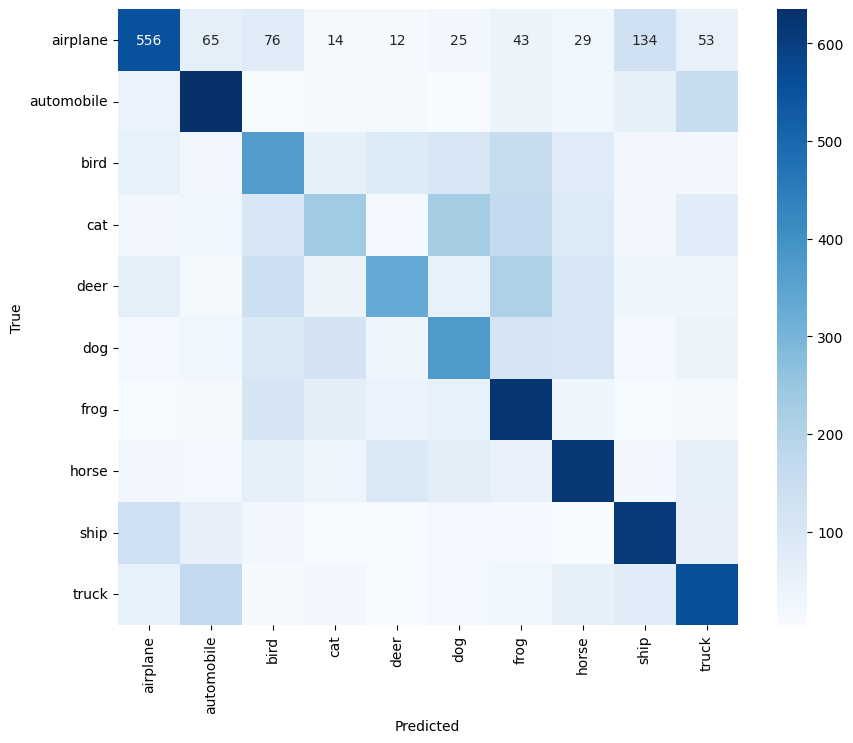

Best Epoch: 44


In [ ]:
adam_expert = Classifier(input_size,
                    num_classes,
                    hidden_units,
                    init_method='kaiming_normal',
                    activation_function=nn.PReLU(),
                    normalization='layer',
                    dropout=0.2)
# plot the model
# expert.plot_model()
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Instantiate the optimizer using the learning rate from Hyperparams
# Instantiate the optimizer using the learning rate from Hyperparams
optimizer = optim.Adam(
    adam_expert.parameters(),
    lr=Hyperparams['learning_rate'],
    weight_decay=Hyperparams['weight_decay'])

best_epoch = experiment_and_evaluate(
    model=adam_expert,
    subtrain_loader=aug_subtrain_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)


### Experiment 6: Ensembling the models

In [ ]:
class Ensemble(nn.Module):
    def __init__(self, models: List[nn.Module]):
        super(Ensemble, self).__init__()
        self.models = models

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        outputs = [model(x) for model in self.models]
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        return avg_output

Epoch 0/500, Train Loss: 2.5054, Train Acc: 0.1714, Val Loss: 2.1140, Val Acc: 0.2306
Epoch 1/500, Train Loss: 2.0947, Train Acc: 0.2266, Val Loss: 1.9194, Val Acc: 0.2873
Epoch 2/500, Train Loss: 2.0221, Train Acc: 0.2497, Val Loss: 1.8852, Val Acc: 0.3408
Epoch 3/500, Train Loss: 1.9808, Train Acc: 0.2734, Val Loss: 1.8161, Val Acc: 0.3395
Epoch 4/500, Train Loss: 1.9505, Train Acc: 0.2814, Val Loss: 1.7720, Val Acc: 0.3618
Epoch 5/500, Train Loss: 1.9316, Train Acc: 0.2938, Val Loss: 1.7234, Val Acc: 0.3768
Epoch 6/500, Train Loss: 1.9062, Train Acc: 0.3066, Val Loss: 1.7158, Val Acc: 0.3879
Epoch 7/500, Train Loss: 1.8728, Train Acc: 0.3233, Val Loss: 1.7037, Val Acc: 0.3914
Epoch 8/500, Train Loss: 1.8709, Train Acc: 0.3149, Val Loss: 1.6942, Val Acc: 0.3846
Epoch 9/500, Train Loss: 1.8610, Train Acc: 0.3247, Val Loss: 1.6635, Val Acc: 0.3967
Epoch 10/500, Train Loss: 1.8633, Train Acc: 0.3200, Val Loss: 1.6772, Val Acc: 0.3974
Epoch 11/500, Train Loss: 1.8420, Train Acc: 0.3332, 

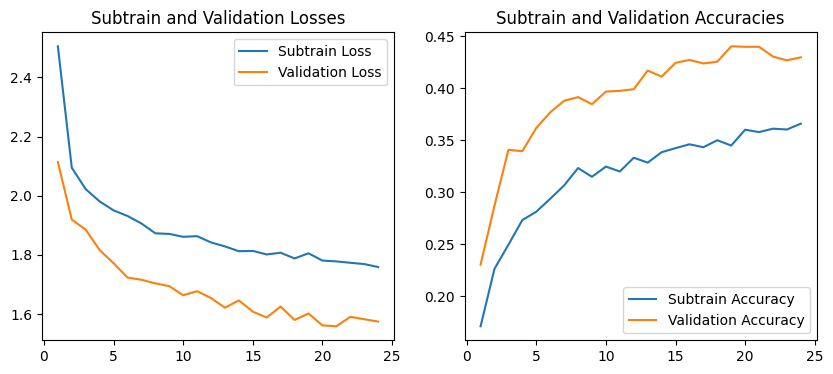

              precision    recall  f1-score   support

    airplane       0.54      0.31      0.39      1007
  automobile       0.51      0.56      0.53      1011
        bird       0.43      0.10      0.16       990
         cat       0.32      0.16      0.22      1002
        deer       0.41      0.39      0.40      1028
         dog       0.33      0.43      0.37       962
        frog       0.42      0.52      0.47       980
       horse       0.47      0.57      0.51      1065
        ship       0.44      0.75      0.55       946
       truck       0.44      0.51      0.47      1009

    accuracy                           0.43     10000
   macro avg       0.43      0.43      0.41     10000
weighted avg       0.43      0.43      0.41     10000



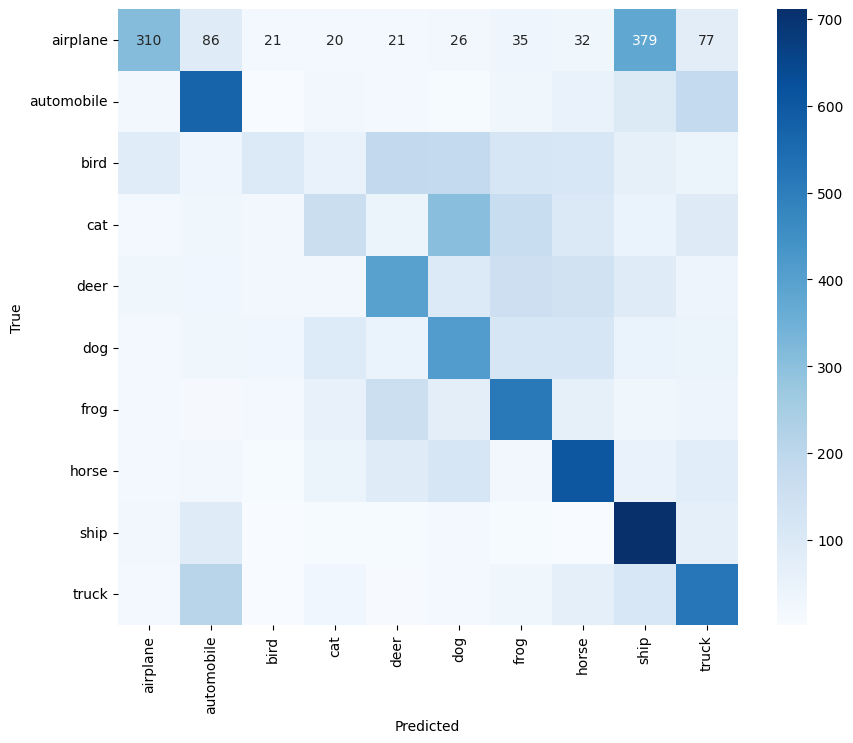

Best Epoch: 18
Epoch 0/500, Train Loss: 2.5052, Train Acc: 0.1728, Val Loss: 2.0391, Val Acc: 0.2463
Epoch 1/500, Train Loss: 2.0868, Train Acc: 0.2254, Val Loss: 1.9606, Val Acc: 0.2715
Epoch 2/500, Train Loss: 2.0262, Train Acc: 0.2527, Val Loss: 1.8893, Val Acc: 0.3052
Epoch 3/500, Train Loss: 1.9641, Train Acc: 0.2759, Val Loss: 1.7993, Val Acc: 0.3376
Epoch 4/500, Train Loss: 1.9316, Train Acc: 0.2896, Val Loss: 1.7659, Val Acc: 0.3741
Epoch 5/500, Train Loss: 1.9139, Train Acc: 0.2988, Val Loss: 1.7492, Val Acc: 0.3746
Epoch 6/500, Train Loss: 1.8974, Train Acc: 0.3052, Val Loss: 1.7295, Val Acc: 0.3735
Epoch 7/500, Train Loss: 1.8705, Train Acc: 0.3216, Val Loss: 1.6936, Val Acc: 0.3883
Epoch 8/500, Train Loss: 1.8670, Train Acc: 0.3202, Val Loss: 1.6693, Val Acc: 0.3941
Epoch 9/500, Train Loss: 1.8503, Train Acc: 0.3271, Val Loss: 1.6840, Val Acc: 0.3909
Epoch 10/500, Train Loss: 1.8519, Train Acc: 0.3258, Val Loss: 1.6594, Val Acc: 0.4075
Epoch 11/500, Train Loss: 1.8391, Trai

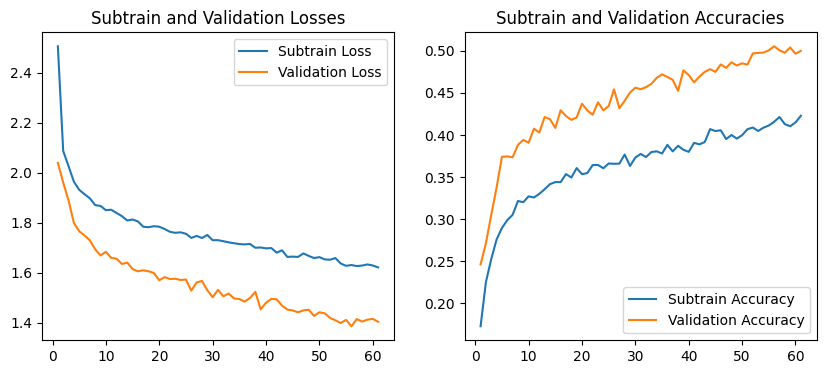

              precision    recall  f1-score   support

    airplane       0.62      0.51      0.56      1007
  automobile       0.53      0.73      0.62      1011
        bird       0.42      0.36      0.39       990
         cat       0.32      0.38      0.35      1002
        deer       0.53      0.39      0.45      1028
         dog       0.45      0.27      0.34       962
        frog       0.49      0.53      0.51       980
       horse       0.58      0.59      0.59      1065
        ship       0.61      0.65      0.63       946
       truck       0.47      0.58      0.52      1009

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.49     10000
weighted avg       0.50      0.50      0.49     10000



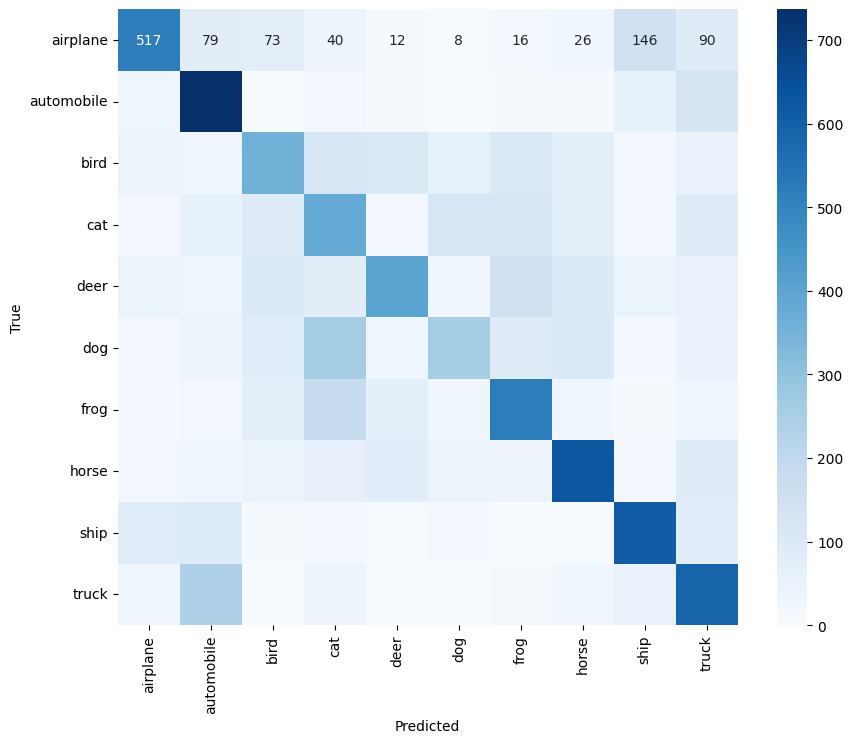

Best Epoch: 55
Epoch 0/500, Train Loss: 2.4404, Train Acc: 0.1839, Val Loss: 2.0358, Val Acc: 0.2685
Epoch 1/500, Train Loss: 2.1002, Train Acc: 0.2270, Val Loss: 1.9000, Val Acc: 0.3039
Epoch 2/500, Train Loss: 2.0151, Train Acc: 0.2522, Val Loss: 1.8473, Val Acc: 0.3294
Epoch 3/500, Train Loss: 1.9778, Train Acc: 0.2677, Val Loss: 1.8089, Val Acc: 0.3318
Epoch 4/500, Train Loss: 1.9380, Train Acc: 0.2923, Val Loss: 1.7641, Val Acc: 0.3699
Epoch 5/500, Train Loss: 1.9237, Train Acc: 0.2932, Val Loss: 1.7465, Val Acc: 0.3736
Epoch 6/500, Train Loss: 1.8921, Train Acc: 0.3103, Val Loss: 1.7194, Val Acc: 0.3805
Epoch 7/500, Train Loss: 1.8850, Train Acc: 0.3160, Val Loss: 1.6969, Val Acc: 0.3910
Epoch 8/500, Train Loss: 1.8739, Train Acc: 0.3218, Val Loss: 1.6880, Val Acc: 0.4042
Epoch 9/500, Train Loss: 1.8559, Train Acc: 0.3245, Val Loss: 1.6691, Val Acc: 0.4080
Epoch 10/500, Train Loss: 1.8466, Train Acc: 0.3273, Val Loss: 1.6954, Val Acc: 0.3937
Epoch 11/500, Train Loss: 1.8323, Trai

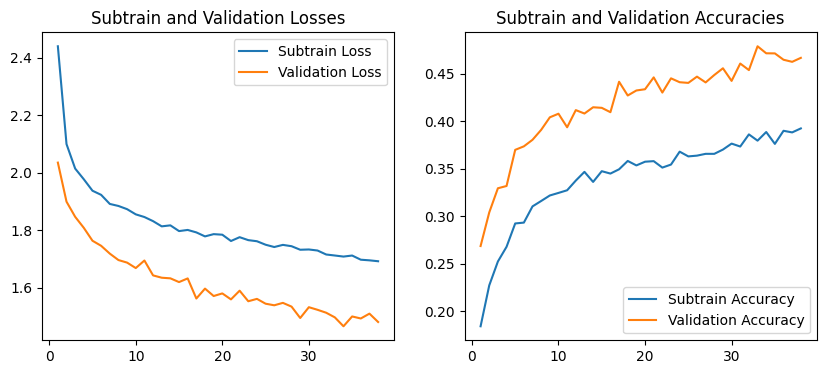

              precision    recall  f1-score   support

    airplane       0.49      0.59      0.54      1007
  automobile       0.67      0.41      0.51      1011
        bird       0.36      0.40      0.38       990
         cat       0.36      0.18      0.24      1002
        deer       0.45      0.38      0.41      1028
         dog       0.41      0.35      0.38       962
        frog       0.46      0.52      0.49       980
       horse       0.51      0.57      0.54      1065
        ship       0.65      0.55      0.60       946
       truck       0.40      0.72      0.52      1009

    accuracy                           0.47     10000
   macro avg       0.48      0.47      0.46     10000
weighted avg       0.48      0.47      0.46     10000



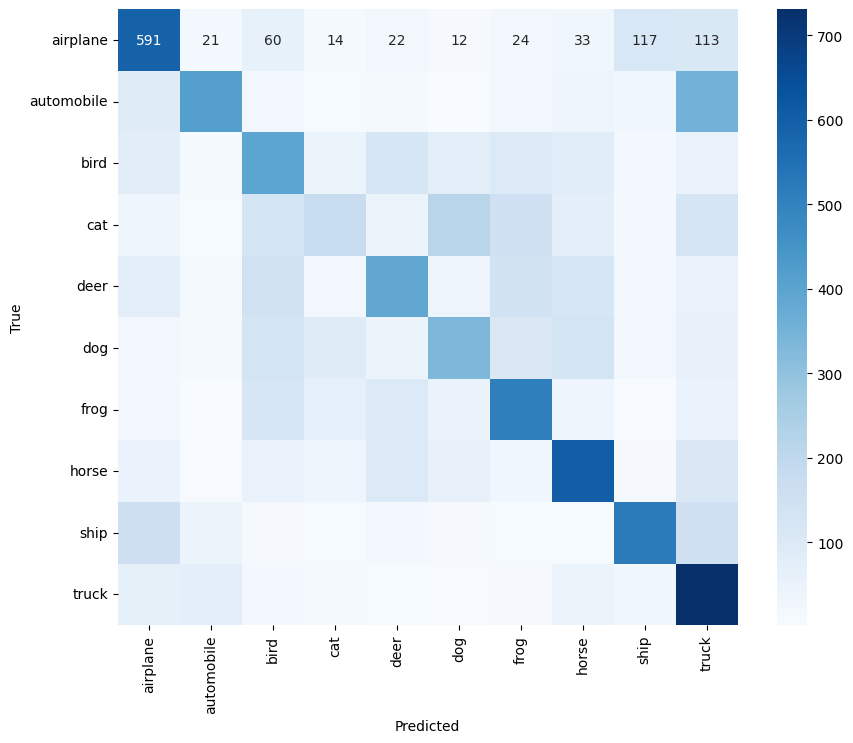

Best Epoch: 32


In [ ]:
ensemble_size = 3
experts = []
for _ in range(ensemble_size):
    expert = Classifier(input_size,
                        num_classes,
                        hidden_units,
                        init_method='kaiming_normal',
                        activation_function=nn.PReLU(),
                        normalization='layer',
                        dropout=0.2)
    # plot the model
    # expert.plot_model()
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    # Instantiate the optimizer using the learning rate from Hyperparams
# Instantiate the optimizer using the learning rate from Hyperparams
    optimizer = optim.Adam(
        expert.parameters(),
        lr=Hyperparams['learning_rate'],
        weight_decay=Hyperparams['weight_decay'])

    best_epoch = experiment_and_evaluate(
        model=expert,
        subtrain_loader=aug_subtrain_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        hyperparams=Hyperparams
    )

    experts.append(expert)

              precision    recall  f1-score   support

    airplane       0.58      0.50      0.54      1007
  automobile       0.59      0.62      0.61      1011
        bird       0.45      0.30      0.36       990
         cat       0.36      0.27      0.31      1002
        deer       0.47      0.40      0.43      1028
         dog       0.41      0.37      0.39       962
        frog       0.46      0.55      0.50       980
       horse       0.54      0.60      0.57      1065
        ship       0.57      0.69      0.62       946
       truck       0.46      0.66      0.54      1009

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.49     10000
weighted avg       0.49      0.50      0.49     10000



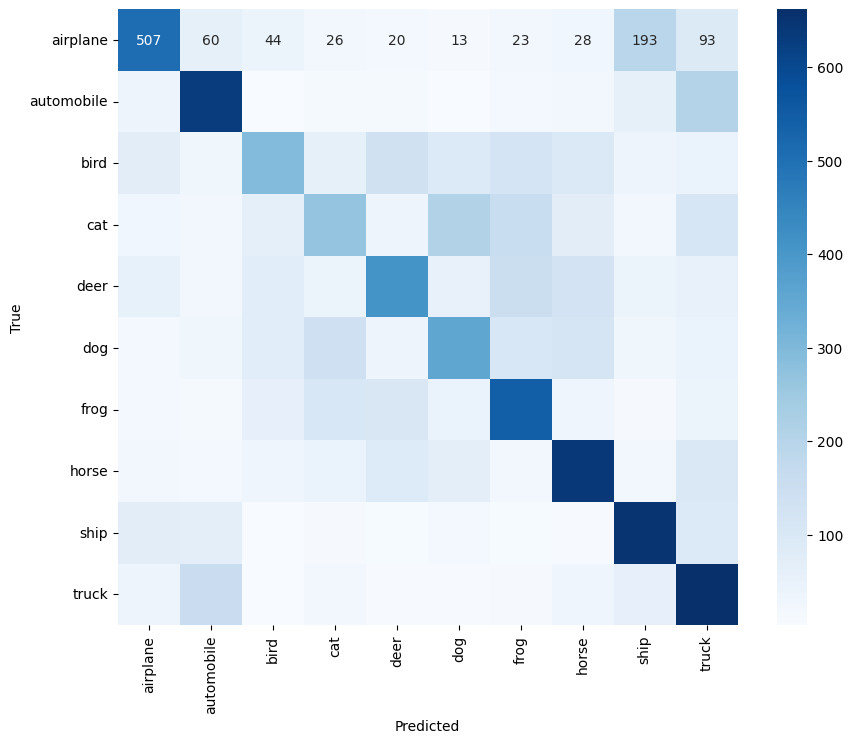

In [ ]:
ensemble_model = Ensemble(experts)
evaluate_and_plot(ensemble_model, val_loader)

# let's put all our learnings from the experiments together and see what kind of performance we can achieve.

Epoch 0/500, Train Loss: 2.2332, Train Acc: 0.2154, Val Loss: 1.8632, Val Acc: 0.3142
Epoch 1/500, Train Loss: 1.9565, Train Acc: 0.2805, Val Loss: 1.7673, Val Acc: 0.3683
Epoch 2/500, Train Loss: 1.8959, Train Acc: 0.3037, Val Loss: 1.6478, Val Acc: 0.4181
Epoch 3/500, Train Loss: 1.8578, Train Acc: 0.3262, Val Loss: 1.6425, Val Acc: 0.4181
Epoch 4/500, Train Loss: 1.8323, Train Acc: 0.3374, Val Loss: 1.5873, Val Acc: 0.4288
Epoch 5/500, Train Loss: 1.8106, Train Acc: 0.3441, Val Loss: 1.6059, Val Acc: 0.4233
Epoch 6/500, Train Loss: 1.8010, Train Acc: 0.3431, Val Loss: 1.5729, Val Acc: 0.4419
Epoch 7/500, Train Loss: 1.7862, Train Acc: 0.3509, Val Loss: 1.5528, Val Acc: 0.4483
Epoch 8/500, Train Loss: 1.7734, Train Acc: 0.3578, Val Loss: 1.5439, Val Acc: 0.4446
Epoch 9/500, Train Loss: 1.7598, Train Acc: 0.3622, Val Loss: 1.5249, Val Acc: 0.4545
Epoch 10/500, Train Loss: 1.7477, Train Acc: 0.3650, Val Loss: 1.4916, Val Acc: 0.4668
Epoch 11/500, Train Loss: 1.7336, Train Acc: 0.3761, 

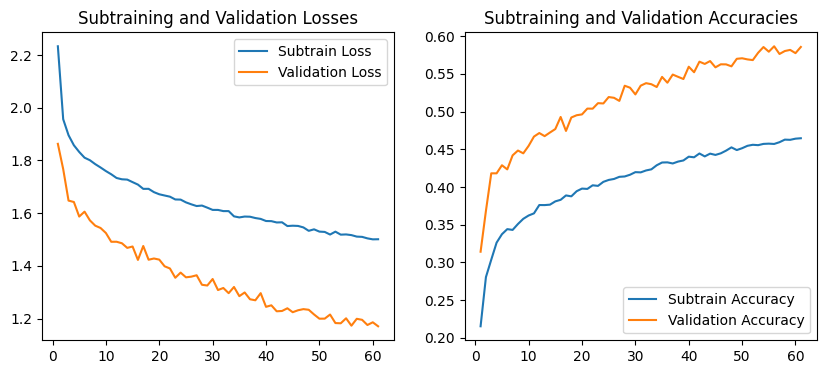

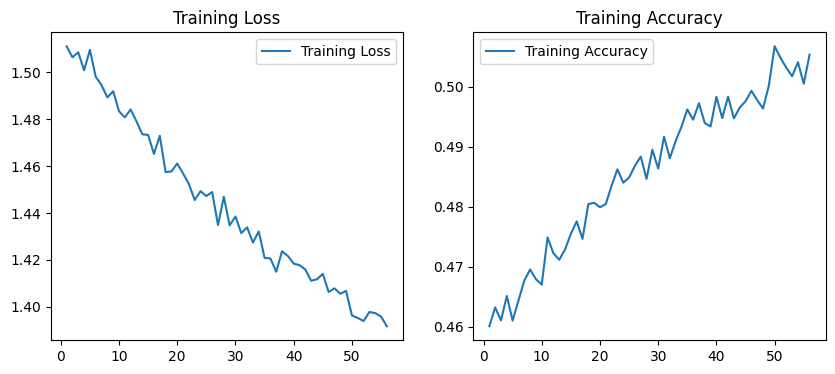

Best Epoch: 55
Training Runtime: 2640.45 seconds
Epoch 0/500, Train Loss: 2.1986, Train Acc: 0.2154, Val Loss: 1.8690, Val Acc: 0.3096
Epoch 1/500, Train Loss: 1.9513, Train Acc: 0.2823, Val Loss: 1.7932, Val Acc: 0.3587
Epoch 2/500, Train Loss: 1.8901, Train Acc: 0.3113, Val Loss: 1.6665, Val Acc: 0.3963
Epoch 3/500, Train Loss: 1.8537, Train Acc: 0.3258, Val Loss: 1.6413, Val Acc: 0.4250
Epoch 4/500, Train Loss: 1.8349, Train Acc: 0.3282, Val Loss: 1.6313, Val Acc: 0.4163
Epoch 5/500, Train Loss: 1.8190, Train Acc: 0.3349, Val Loss: 1.5755, Val Acc: 0.4342
Epoch 6/500, Train Loss: 1.7910, Train Acc: 0.3489, Val Loss: 1.5772, Val Acc: 0.4362
Epoch 7/500, Train Loss: 1.7808, Train Acc: 0.3552, Val Loss: 1.5272, Val Acc: 0.4541
Epoch 8/500, Train Loss: 1.7680, Train Acc: 0.3615, Val Loss: 1.5648, Val Acc: 0.4382
Epoch 9/500, Train Loss: 1.7591, Train Acc: 0.3601, Val Loss: 1.5188, Val Acc: 0.4539
Epoch 10/500, Train Loss: 1.7473, Train Acc: 0.3654, Val Loss: 1.5361, Val Acc: 0.4589
Epoc

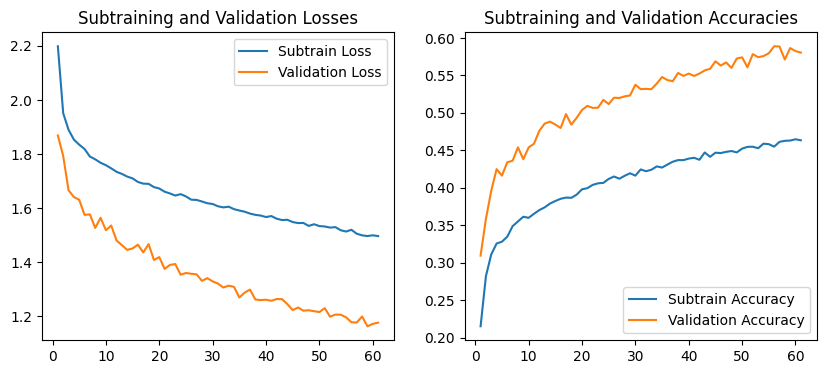

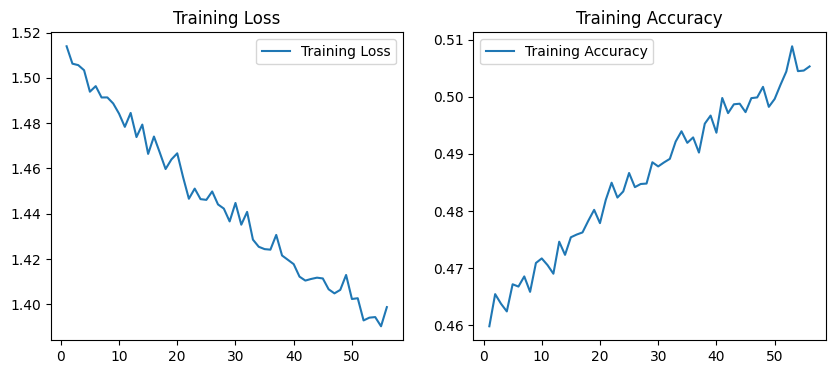

Best Epoch: 55
Training Runtime: 2791.72 seconds
Epoch 0/500, Train Loss: 2.1814, Train Acc: 0.2207, Val Loss: 1.8478, Val Acc: 0.3322
Epoch 1/500, Train Loss: 1.9530, Train Acc: 0.2777, Val Loss: 1.7472, Val Acc: 0.3627
Epoch 2/500, Train Loss: 1.8934, Train Acc: 0.3036, Val Loss: 1.6927, Val Acc: 0.3938
Epoch 3/500, Train Loss: 1.8600, Train Acc: 0.3206, Val Loss: 1.6580, Val Acc: 0.4054
Epoch 4/500, Train Loss: 1.8320, Train Acc: 0.3335, Val Loss: 1.6158, Val Acc: 0.4179
Epoch 5/500, Train Loss: 1.8151, Train Acc: 0.3366, Val Loss: 1.6026, Val Acc: 0.4218
Epoch 6/500, Train Loss: 1.7973, Train Acc: 0.3480, Val Loss: 1.5870, Val Acc: 0.4273
Epoch 7/500, Train Loss: 1.7826, Train Acc: 0.3535, Val Loss: 1.5452, Val Acc: 0.4579
Epoch 8/500, Train Loss: 1.7691, Train Acc: 0.3620, Val Loss: 1.5581, Val Acc: 0.4367
Epoch 9/500, Train Loss: 1.7563, Train Acc: 0.3632, Val Loss: 1.5284, Val Acc: 0.4627
Epoch 10/500, Train Loss: 1.7490, Train Acc: 0.3670, Val Loss: 1.4978, Val Acc: 0.4686
Epoc

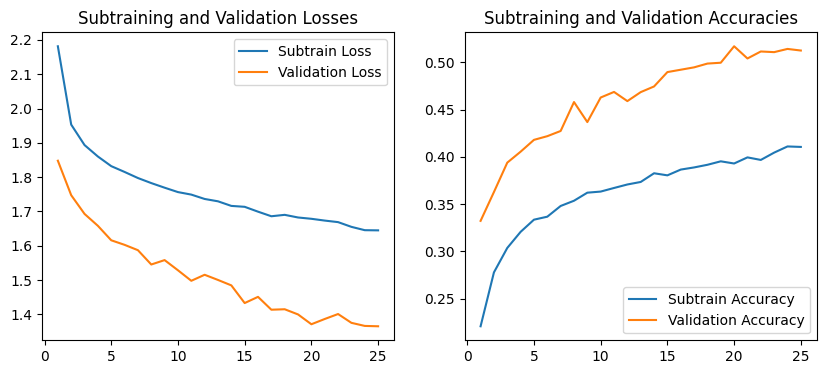

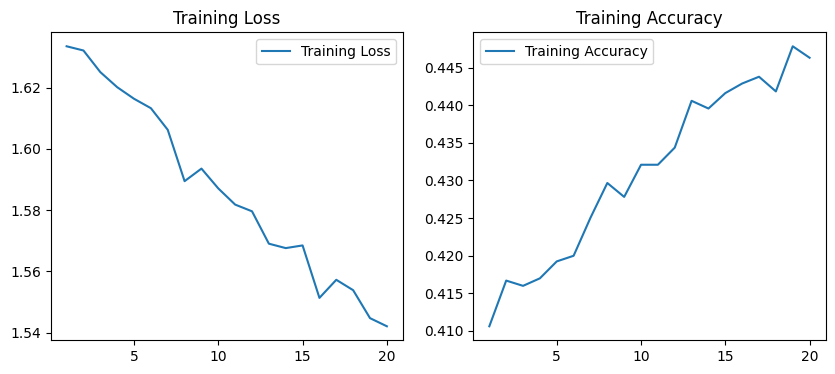

Best Epoch: 19
Training Runtime: 931.45 seconds


In [ ]:
ensemble_size = 3
adam_experts = []

for _ in range(ensemble_size):
    expert = Classifier(input_size,
                        num_classes,
                        hidden_units,
                        init_method='kaiming_normal',
                        activation_function=nn.PReLU(),
                        normalization='layer',
                        dropout=0.2)
    # plot the model
    # expert.plot_model()
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    # Instantiate the optimizer using the learning rate from Hyperparams
    optimizer = optim.Adam(
        expert.parameters(),
        lr=Hyperparams['learning_rate'],
        weight_decay=Hyperparams['weight_decay'])

    best_epoch, training_runtime = train_and_evaluate(
        model=expert,
        subtrain_loader=aug_subtrain_loader,
        train_loader=aug_train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        hyperparams=Hyperparams
    )

    adam_experts.append(expert)

              precision    recall  f1-score   support

    airplane       0.67      0.75      0.71       999
  automobile       0.70      0.77      0.73       988
        bird       0.58      0.55      0.56      1002
         cat       0.56      0.34      0.43      1059
        deer       0.53      0.61      0.56       931
         dog       0.58      0.53      0.55      1032
        frog       0.67      0.71      0.69      1049
       horse       0.73      0.72      0.72       960
        ship       0.76      0.78      0.77       986
       truck       0.65      0.70      0.67       994

    accuracy                           0.64     10000
   macro avg       0.64      0.65      0.64     10000
weighted avg       0.64      0.64      0.64     10000



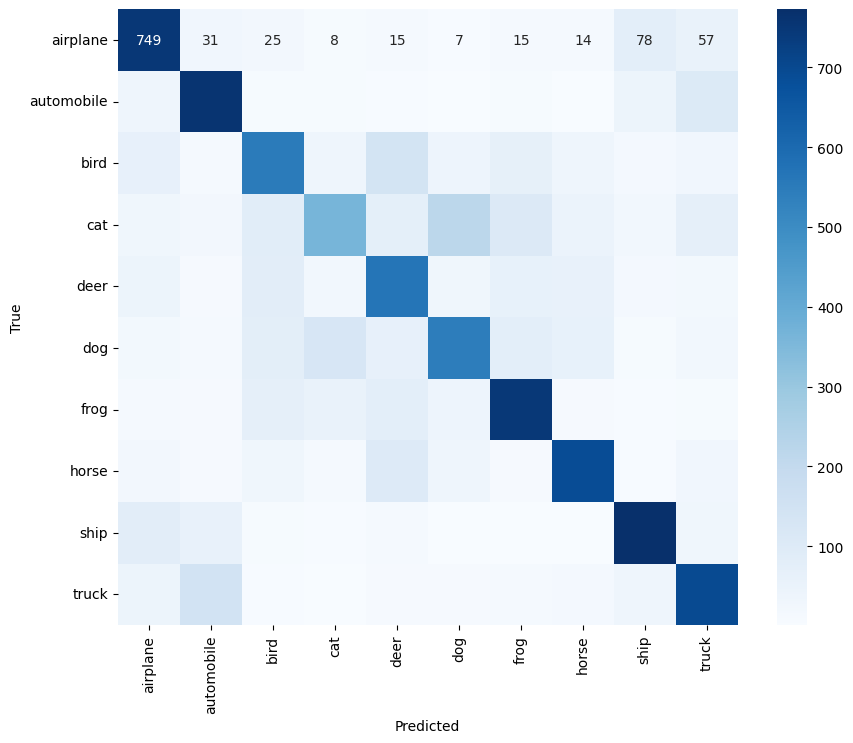

In [ ]:
adam_ensemble_model = Ensemble(adam_experts)
evaluate_and_plot(adam_ensemble_model, test_loader)

Little disappointed here 64%, because in a different notebook, We are able to achieve 70% accuracy on the test set with all the tricks we have experimented with put together. 

# Optional Mixer architecture
we are going to try to implement the mlp mixer architecture according to the  paper: https://arxiv.org/pdf/2105.01601.pdf

In [30]:
class MlpBlock(nn.Module):
    """MLP block layer with activation function."""
    def __init__(self, dim: int, hidden_dim: int, activation_fn: nn.Module = nn.GELU()):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            activation_fn,
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class MixerBlock(nn.Module):
    """Mixer block layer with Layer Normalization."""
    def __init__(self, token_dim: int, channel_dim: int, seq_len: int, activation_fn: nn.Module, dropout: float):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(token_dim)
        self.token_mlp = MlpBlock(seq_len, seq_len, activation_fn)
        
        self.layer_norm2 = nn.LayerNorm(token_dim)
        self.channel_mlp = MlpBlock(token_dim, channel_dim, activation_fn)
        
        self.dropout = nn.Dropout(dropout) if dropout else None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer_norm1(x)
        x = x + self.token_mlp(x.transpose(1, 2)).transpose(1, 2)
        
        if self.dropout:
            x = self.dropout(x)
        
        x = self.layer_norm2(x)
        x = x + self.channel_mlp(x)
        
        return x

class MlpMixer(nn.Module):
    """MLP-Mixer architecture with pre-head Layer Normalization."""
    def __init__(self, num_classes: int, num_blocks: int, patch_size: int, image_size: int, 
                 channels: int, token_dim: int, channel_dim: int, init_method: str, dropout: float, 
                 activation_fn: nn.Module):
        super(MlpMixer, self).__init__()

        self.patch_size = patch_size

        num_patches = (image_size // patch_size)**2
        self.patch_embedding = nn.Linear(patch_size * patch_size * channels, token_dim)
        
        self.mixer_blocks = nn.ModuleList([
            MixerBlock(token_dim, channel_dim, num_patches, activation_fn, dropout) for _ in range(num_blocks)
        ])
        
        self.pre_head_layer_norm = nn.LayerNorm(token_dim)
        
        self.classifier = nn.Linear(token_dim, num_classes)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if init_method == 'kaiming_normal':
                    nn.init.kaiming_normal_(m.weight)
                elif init_method == 'xavier_uniform':
                    nn.init.xavier_uniform_(m.weight)

        # Device placement
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        x = self.patch_embedding(x)
        for block in self.mixer_blocks:
            x = block(x)
        x = self.pre_head_layer_norm(x)
        x = x.mean(dim=1)
        x = self.classifier(x)
        return x
    
    def plot_model(self):
        """
        Display the summary and plot the network.
        """
        # input_size is channels x height x width
        input_size = (3, 32, 32)  # Assuming CIFAR-10-like images

        original_device = next(self.parameters()).device  # Store the original device
        self.to('cpu')  # Temporarily move model to CPU

        summary(self, input_size=input_size, device='cpu')  # Print summary

        # x = torch.randn(1, *input_size, device='cpu')  # Create a random input tensor on the CPU
        # y = self(x)
        # dot = make_dot(y, params=dict(self.named_parameters()))  # Create computation graph
        # dot.render(format='png', filename='network_graph')  # Save computation graph to file
        # plt.imshow(plt.imread('network_graph.png'))  # Display computation graph
        # plt.axis('off')
        # plt.show()

        self.to(original_device)  # Move model back to its original device


In [32]:
mlp_mixer_model = MlpMixer(
    num_classes=10,
    num_blocks=4,
    patch_size=4,
    image_size=32,
    channels=3,
    token_dim=128,
    channel_dim=1024,
    init_method='kaiming_normal',
    dropout=.2,
    activation_fn=nn.PReLU()
)

# plot the model
mlp_mixer_model.plot_model()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 64, 128]           6,272
         LayerNorm-2              [-1, 64, 128]             256
            Linear-3              [-1, 128, 64]           4,160
             PReLU-4              [-1, 128, 64]               1
             PReLU-5              [-1, 128, 64]               1
             PReLU-6              [-1, 128, 64]               1
             PReLU-7              [-1, 128, 64]               1
             PReLU-8              [-1, 128, 64]               1
             PReLU-9              [-1, 128, 64]               1
            PReLU-10              [-1, 128, 64]               1
            PReLU-11              [-1, 128, 64]               1
           Linear-12              [-1, 128, 64]           4,160
         MlpBlock-13              [-1, 128, 64]               0
          Dropout-14              [-1, 

Epoch 0/500, Train Loss: 2.2319, Train Acc: 0.1704, Val Loss: 2.0259, Val Acc: 0.2623
Epoch 1/500, Train Loss: 2.0534, Train Acc: 0.2362, Val Loss: 1.9189, Val Acc: 0.3012
Epoch 2/500, Train Loss: 1.9931, Train Acc: 0.2672, Val Loss: 1.8737, Val Acc: 0.3241
Epoch 3/500, Train Loss: 1.9761, Train Acc: 0.2768, Val Loss: 1.8154, Val Acc: 0.3549
Epoch 4/500, Train Loss: 1.9616, Train Acc: 0.2854, Val Loss: 1.7686, Val Acc: 0.3614
Epoch 5/500, Train Loss: 1.9393, Train Acc: 0.2849, Val Loss: 1.8079, Val Acc: 0.3413
Epoch 6/500, Train Loss: 1.9174, Train Acc: 0.3012, Val Loss: 1.7542, Val Acc: 0.3682
Epoch 7/500, Train Loss: 1.8966, Train Acc: 0.3056, Val Loss: 1.7557, Val Acc: 0.3635
Epoch 8/500, Train Loss: 1.8875, Train Acc: 0.3084, Val Loss: 1.7445, Val Acc: 0.3707
Epoch 9/500, Train Loss: 1.8703, Train Acc: 0.3191, Val Loss: 1.7094, Val Acc: 0.3889
Epoch 10/500, Train Loss: 1.8570, Train Acc: 0.3175, Val Loss: 1.6981, Val Acc: 0.3894
Epoch 11/500, Train Loss: 1.8411, Train Acc: 0.3313, 

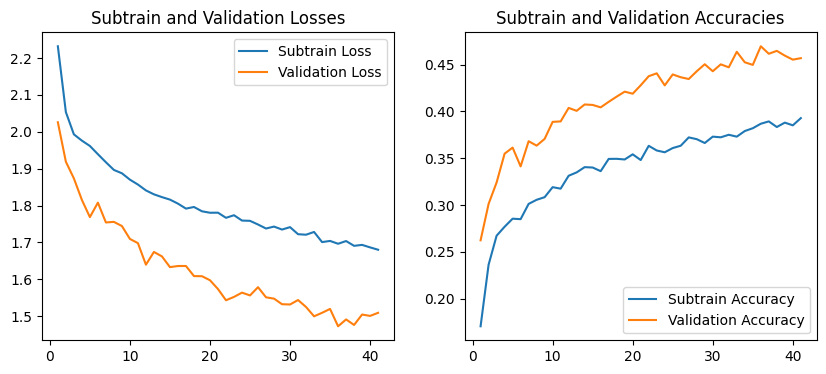

              precision    recall  f1-score   support

    airplane       0.52      0.52      0.52      1007
  automobile       0.57      0.51      0.54      1011
        bird       0.39      0.23      0.29       990
         cat       0.28      0.24      0.26      1002
        deer       0.37      0.54      0.44      1028
         dog       0.37      0.44      0.40       962
        frog       0.52      0.48      0.50       980
       horse       0.50      0.49      0.50      1065
        ship       0.55      0.71      0.62       946
       truck       0.50      0.42      0.46      1009

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.45     10000
weighted avg       0.46      0.46      0.45     10000



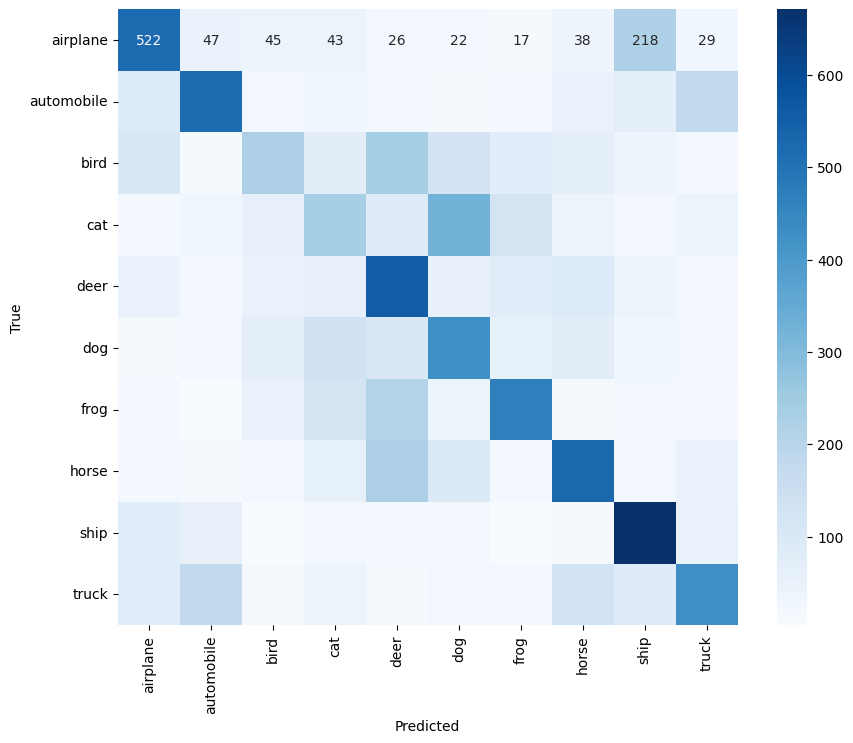

Best Epoch: 35


In [ ]:
# Initialize the model
mlp_mixer_model = MlpMixer(
    num_classes=10,
    num_blocks=6,
    patch_size=8,
    image_size=32,
    channels=3,
    token_dim=256,
    channel_dim=1024,
    init_method='kaiming_normal',
    dropout=.2,
    activation_fn=nn.PReLU()
)

# Hyperparameters for training
Hyperparams['learning_rate'] = 1e-3
Hyperparams['weight_decay'] = 1e-7

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_mixer_model.parameters(), 
                 lr=Hyperparams['learning_rate'], 
                 weight_decay=Hyperparams['weight_decay'])

# Your DataLoader objects: `aug_subtrain_loader` and `val_loader` should be defined before this line.
# Now you can proceed with training using your existing `experiment_and_evaluate` function
best_epoch = experiment_and_evaluate(
    model=mlp_mixer_model,
    subtrain_loader=aug_subtrain_loader,  # Make sure your DataLoader puts the data to the correct device
    val_loader=val_loader,  # Make sure your DataLoader puts the data to the correct device
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

This is a nice try at 46% on validation. Now let's scale this up to more data

Epoch 0/500, Train Loss: 2.0866, Train Acc: 0.2247, Val Loss: 1.9168, Val Acc: 0.2871
Epoch 1/500, Train Loss: 1.9788, Train Acc: 0.2658, Val Loss: 1.8485, Val Acc: 0.3334
Epoch 2/500, Train Loss: 1.9294, Train Acc: 0.2869, Val Loss: 1.7811, Val Acc: 0.3501
Epoch 3/500, Train Loss: 1.8779, Train Acc: 0.3094, Val Loss: 1.7372, Val Acc: 0.3826
Epoch 4/500, Train Loss: 1.8487, Train Acc: 0.3259, Val Loss: 1.6586, Val Acc: 0.4020
Epoch 5/500, Train Loss: 1.8241, Train Acc: 0.3299, Val Loss: 1.6320, Val Acc: 0.4090
Epoch 6/500, Train Loss: 1.8011, Train Acc: 0.3421, Val Loss: 1.6332, Val Acc: 0.4124
Epoch 7/500, Train Loss: 1.7769, Train Acc: 0.3499, Val Loss: 1.5875, Val Acc: 0.4201
Epoch 8/500, Train Loss: 1.7644, Train Acc: 0.3535, Val Loss: 1.5844, Val Acc: 0.4303
Epoch 9/500, Train Loss: 1.7508, Train Acc: 0.3558, Val Loss: 1.5597, Val Acc: 0.4371
Epoch 10/500, Train Loss: 1.7409, Train Acc: 0.3669, Val Loss: 1.5352, Val Acc: 0.4443
Epoch 11/500, Train Loss: 1.7225, Train Acc: 0.3744, 

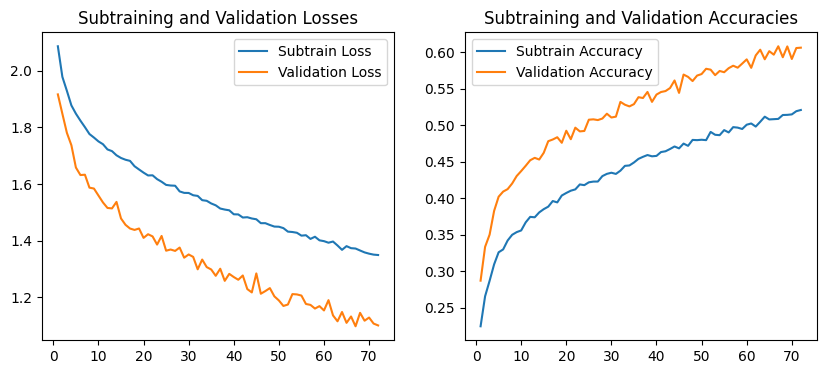

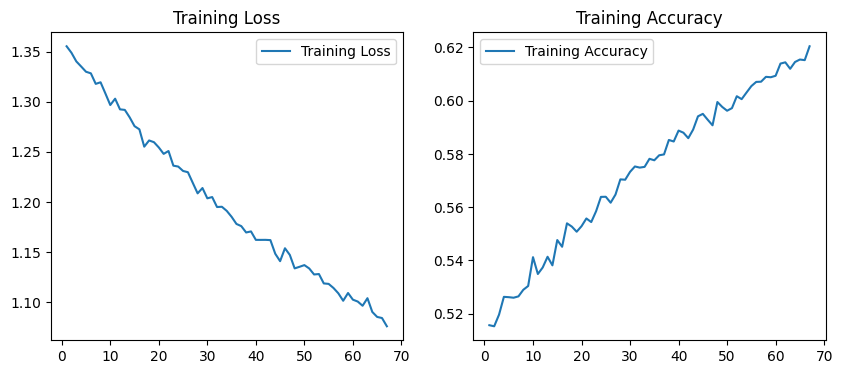

Best Epoch: 66
Training Runtime: 4148.07 seconds
Epoch 0/500, Train Loss: 2.0885, Train Acc: 0.2280, Val Loss: 1.8782, Val Acc: 0.3195
Epoch 1/500, Train Loss: 1.9607, Train Acc: 0.2725, Val Loss: 1.7832, Val Acc: 0.3621
Epoch 2/500, Train Loss: 1.8999, Train Acc: 0.3038, Val Loss: 1.7213, Val Acc: 0.3784
Epoch 3/500, Train Loss: 1.8644, Train Acc: 0.3152, Val Loss: 1.6945, Val Acc: 0.3983
Epoch 4/500, Train Loss: 1.8313, Train Acc: 0.3297, Val Loss: 1.6889, Val Acc: 0.3970
Epoch 5/500, Train Loss: 1.8098, Train Acc: 0.3360, Val Loss: 1.6327, Val Acc: 0.4217
Epoch 6/500, Train Loss: 1.7926, Train Acc: 0.3452, Val Loss: 1.5766, Val Acc: 0.4425
Epoch 7/500, Train Loss: 1.7721, Train Acc: 0.3517, Val Loss: 1.5914, Val Acc: 0.4244
Epoch 8/500, Train Loss: 1.7581, Train Acc: 0.3565, Val Loss: 1.5361, Val Acc: 0.4389
Epoch 9/500, Train Loss: 1.7460, Train Acc: 0.3602, Val Loss: 1.5214, Val Acc: 0.4447
Epoch 10/500, Train Loss: 1.7385, Train Acc: 0.3656, Val Loss: 1.5352, Val Acc: 0.4478
Epoc

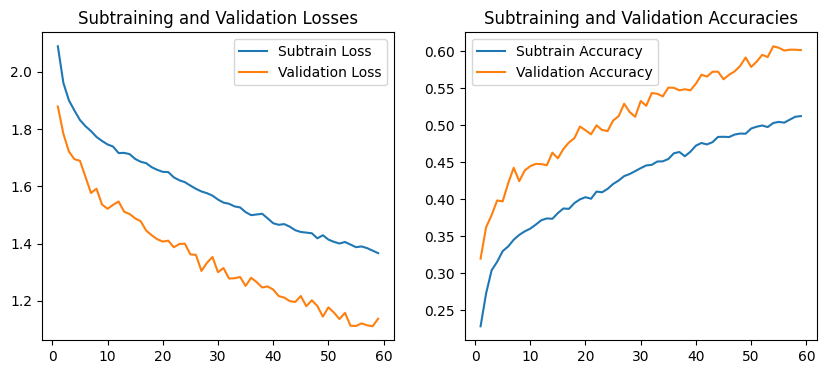

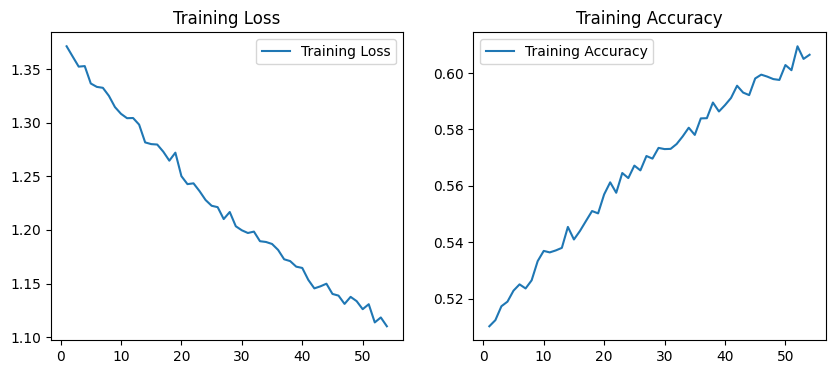

Best Epoch: 53
Training Runtime: 3488.52 seconds
Epoch 0/500, Train Loss: 2.0789, Train Acc: 0.2232, Val Loss: 1.8797, Val Acc: 0.3095
Epoch 1/500, Train Loss: 1.9472, Train Acc: 0.2804, Val Loss: 1.7474, Val Acc: 0.3723
Epoch 2/500, Train Loss: 1.8824, Train Acc: 0.3083, Val Loss: 1.6890, Val Acc: 0.3872
Epoch 3/500, Train Loss: 1.8507, Train Acc: 0.3244, Val Loss: 1.7280, Val Acc: 0.3669
Epoch 4/500, Train Loss: 1.8369, Train Acc: 0.3296, Val Loss: 1.6318, Val Acc: 0.4093
Epoch 5/500, Train Loss: 1.8132, Train Acc: 0.3380, Val Loss: 1.6142, Val Acc: 0.4168
Epoch 6/500, Train Loss: 1.7958, Train Acc: 0.3416, Val Loss: 1.5805, Val Acc: 0.4336
Epoch 7/500, Train Loss: 1.7818, Train Acc: 0.3449, Val Loss: 1.5749, Val Acc: 0.4337
Epoch 8/500, Train Loss: 1.7654, Train Acc: 0.3545, Val Loss: 1.5510, Val Acc: 0.4359
Epoch 9/500, Train Loss: 1.7598, Train Acc: 0.3536, Val Loss: 1.5436, Val Acc: 0.4420
Epoch 10/500, Train Loss: 1.7447, Train Acc: 0.3631, Val Loss: 1.5595, Val Acc: 0.4401
Epoc

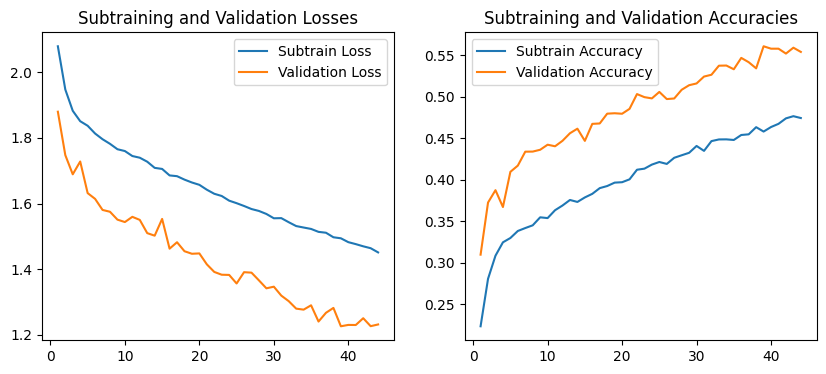

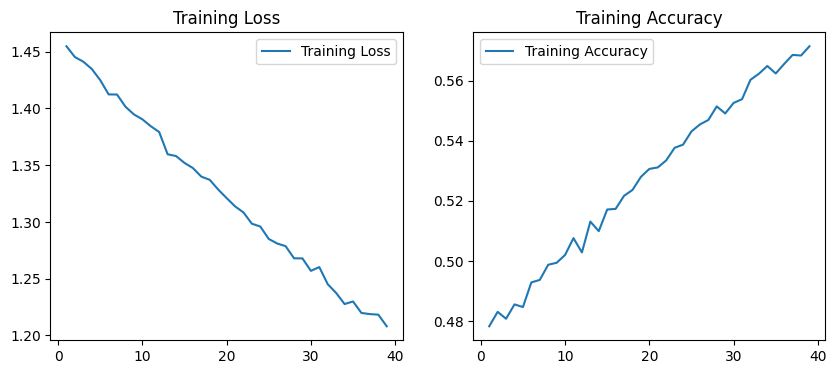

Best Epoch: 38
Training Runtime: 2152.39 seconds


In [ ]:
ensemble_size = 3
mixer_experts = []

for _ in range(ensemble_size):
    mlp_mixer_model = MlpMixer(
        num_classes=10,
        num_blocks=6,
        patch_size=8,
        image_size=32,
        channels=3,
        token_dim=256,
        channel_dim=1024,
        init_method='kaiming_normal',
        dropout=.2,
        activation_fn=nn.PReLU()
    )

    # Hyperparameters for training
    Hyperparams['learning_rate'] = 1e-3
    Hyperparams['weight_decay'] = 1e-7

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mlp_mixer_model.parameters(), 
                    lr=Hyperparams['learning_rate'], 
                    weight_decay=Hyperparams['weight_decay'])

    best_epoch, training_runtime = train_and_evaluate(
        model=mlp_mixer_model,
        subtrain_loader=aug_subtrain_loader,
        train_loader=aug_train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        hyperparams=Hyperparams
    )

    mixer_experts.append(mlp_mixer_model)

              precision    recall  f1-score   support

    airplane       0.78      0.79      0.79       999
  automobile       0.76      0.87      0.81       988
        bird       0.72      0.60      0.66      1002
         cat       0.65      0.42      0.51      1059
        deer       0.69      0.69      0.69       931
         dog       0.65      0.65      0.65      1032
        frog       0.66      0.88      0.75      1049
       horse       0.77      0.78      0.77       960
        ship       0.86      0.85      0.85       986
       truck       0.75      0.79      0.77       994

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.72     10000



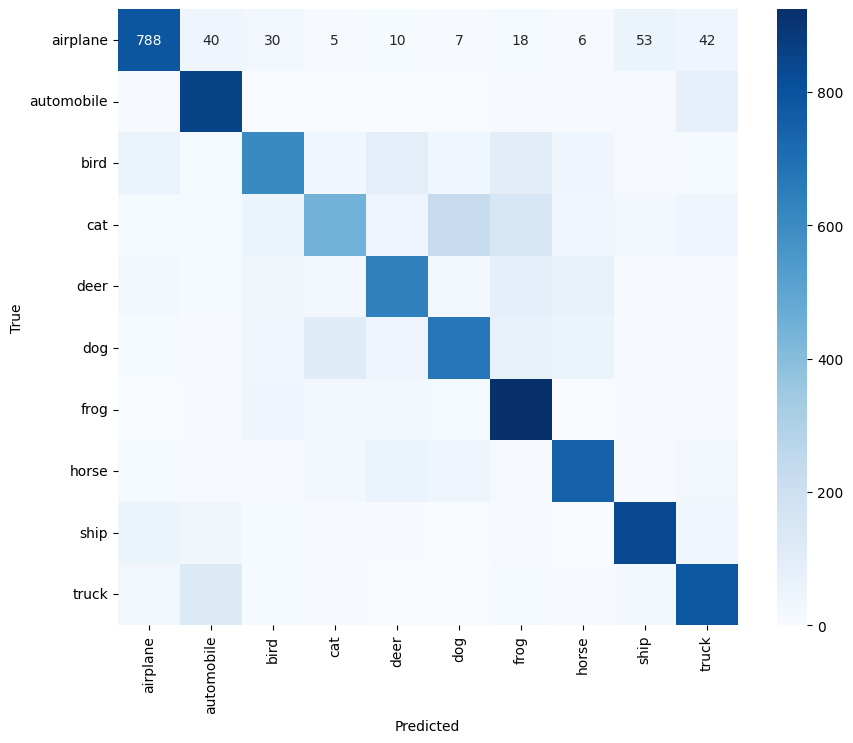

In [ ]:
mixer_ensemble_model = Ensemble(mixer_experts)
evaluate_and_plot(mixer_ensemble_model, test_loader)

73% percent is not bad at all. Next,  let's try with smaller patch sizes and a smaller architecture so there is less parameters to overfit.

Epoch 0/500, Train Loss: 2.0302, Train Acc: 0.2480, Val Loss: 1.7731, Val Acc: 0.3574
Epoch 1/500, Train Loss: 1.8424, Train Acc: 0.3218, Val Loss: 1.6291, Val Acc: 0.4075
Epoch 2/500, Train Loss: 1.7718, Train Acc: 0.3472, Val Loss: 1.5355, Val Acc: 0.4478
Epoch 3/500, Train Loss: 1.7357, Train Acc: 0.3669, Val Loss: 1.4990, Val Acc: 0.4607
Epoch 4/500, Train Loss: 1.7035, Train Acc: 0.3807, Val Loss: 1.5080, Val Acc: 0.4565
Epoch 5/500, Train Loss: 1.6689, Train Acc: 0.3918, Val Loss: 1.4318, Val Acc: 0.4786
Epoch 6/500, Train Loss: 1.6444, Train Acc: 0.4029, Val Loss: 1.4234, Val Acc: 0.4769
Epoch 7/500, Train Loss: 1.6247, Train Acc: 0.4117, Val Loss: 1.3541, Val Acc: 0.5094
Epoch 8/500, Train Loss: 1.5997, Train Acc: 0.4206, Val Loss: 1.3487, Val Acc: 0.5075
Epoch 9/500, Train Loss: 1.5882, Train Acc: 0.4204, Val Loss: 1.3414, Val Acc: 0.5111
Epoch 10/500, Train Loss: 1.5825, Train Acc: 0.4302, Val Loss: 1.3658, Val Acc: 0.5105
Epoch 11/500, Train Loss: 1.5560, Train Acc: 0.4364, 

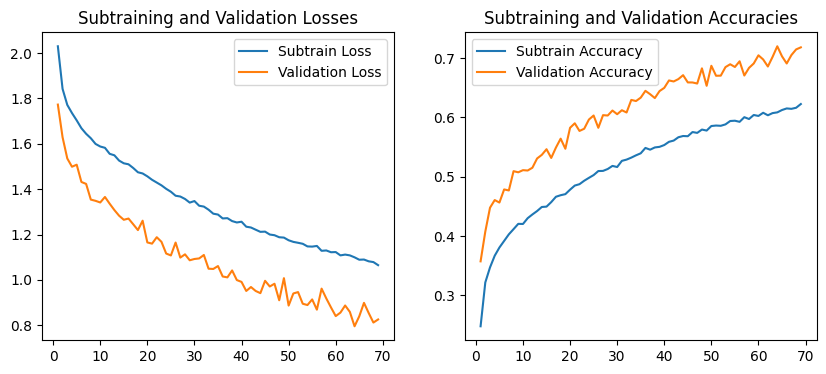

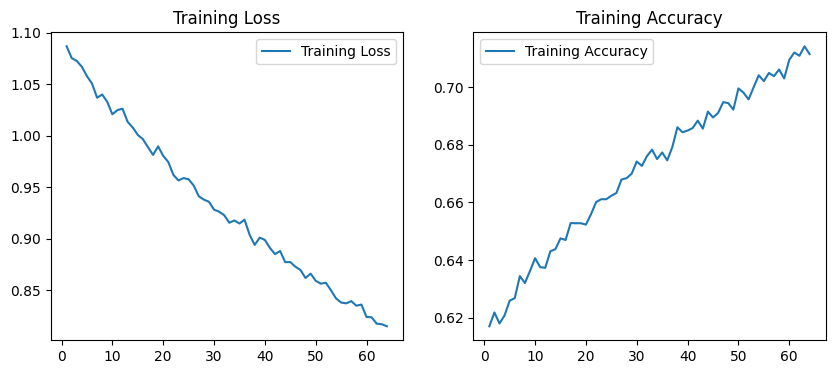

Best Epoch: 63
Training Runtime: 3388.43 seconds
Epoch 0/500, Train Loss: 2.0375, Train Acc: 0.2436, Val Loss: 1.7638, Val Acc: 0.3595
Epoch 1/500, Train Loss: 1.8576, Train Acc: 0.3189, Val Loss: 1.6111, Val Acc: 0.4217
Epoch 2/500, Train Loss: 1.7930, Train Acc: 0.3403, Val Loss: 1.5556, Val Acc: 0.4379
Epoch 3/500, Train Loss: 1.7464, Train Acc: 0.3636, Val Loss: 1.5428, Val Acc: 0.4506
Epoch 4/500, Train Loss: 1.7200, Train Acc: 0.3736, Val Loss: 1.4755, Val Acc: 0.4603
Epoch 5/500, Train Loss: 1.6893, Train Acc: 0.3815, Val Loss: 1.4240, Val Acc: 0.4805
Epoch 6/500, Train Loss: 1.6616, Train Acc: 0.3979, Val Loss: 1.4186, Val Acc: 0.4858
Epoch 7/500, Train Loss: 1.6357, Train Acc: 0.4057, Val Loss: 1.3787, Val Acc: 0.5064
Epoch 8/500, Train Loss: 1.6196, Train Acc: 0.4150, Val Loss: 1.4001, Val Acc: 0.4935
Epoch 9/500, Train Loss: 1.5936, Train Acc: 0.4255, Val Loss: 1.3431, Val Acc: 0.5149
Epoch 10/500, Train Loss: 1.5696, Train Acc: 0.4337, Val Loss: 1.3107, Val Acc: 0.5307
Epoc

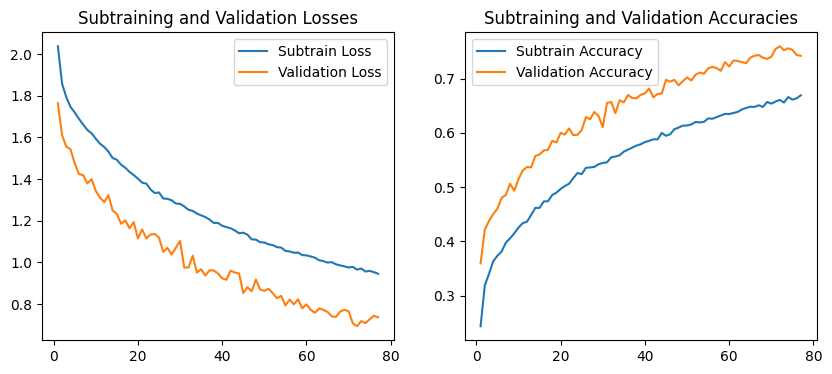

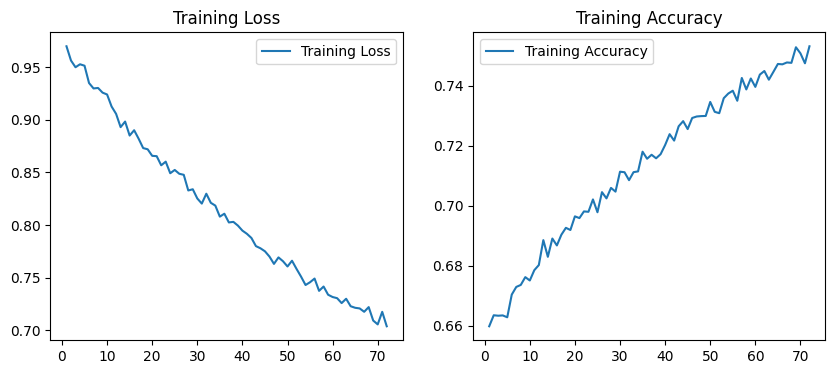

Best Epoch: 71
Training Runtime: 3804.40 seconds
Epoch 0/500, Train Loss: 2.0253, Train Acc: 0.2468, Val Loss: 1.7615, Val Acc: 0.3691
Epoch 1/500, Train Loss: 1.8360, Train Acc: 0.3285, Val Loss: 1.6181, Val Acc: 0.4218
Epoch 2/500, Train Loss: 1.7608, Train Acc: 0.3582, Val Loss: 1.5459, Val Acc: 0.4459
Epoch 3/500, Train Loss: 1.7234, Train Acc: 0.3661, Val Loss: 1.4669, Val Acc: 0.4682
Epoch 4/500, Train Loss: 1.6878, Train Acc: 0.3837, Val Loss: 1.4370, Val Acc: 0.4791
Epoch 5/500, Train Loss: 1.6640, Train Acc: 0.3955, Val Loss: 1.4389, Val Acc: 0.4855
Epoch 6/500, Train Loss: 1.6354, Train Acc: 0.4065, Val Loss: 1.3767, Val Acc: 0.5030
Epoch 7/500, Train Loss: 1.6165, Train Acc: 0.4153, Val Loss: 1.3934, Val Acc: 0.4910
Epoch 8/500, Train Loss: 1.5970, Train Acc: 0.4232, Val Loss: 1.3588, Val Acc: 0.5035
Epoch 9/500, Train Loss: 1.5800, Train Acc: 0.4276, Val Loss: 1.3115, Val Acc: 0.5233
Epoch 10/500, Train Loss: 1.5685, Train Acc: 0.4339, Val Loss: 1.3082, Val Acc: 0.5254
Epoc

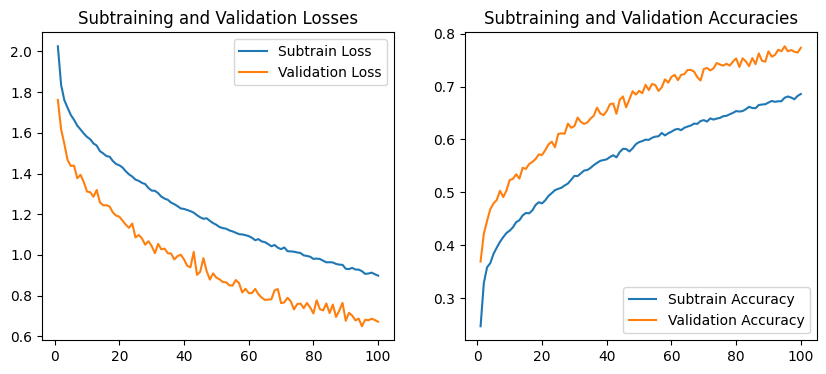

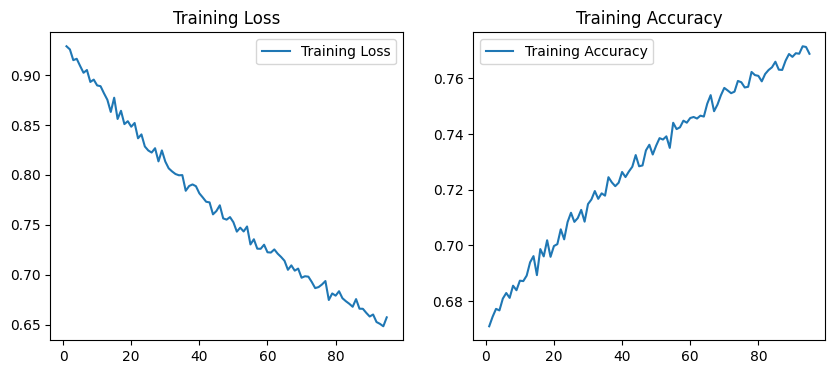

Best Epoch: 94
Training Runtime: 5010.55 seconds


In [ ]:
ensemble_size = 3
mixer_experts = []

for _ in range(ensemble_size):
    mlp_mixer_model = MlpMixer(
        num_classes=10,
        num_blocks=4,
        patch_size=4,
        image_size=32,
        channels=3,
        token_dim=128,
        channel_dim=1024,
        init_method='kaiming_normal',
        dropout=.2,
        activation_fn=nn.PReLU()
    )

    # Hyperparameters for training
    Hyperparams['learning_rate'] = 1e-3
    Hyperparams['weight_decay'] = 1e-7

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mlp_mixer_model.parameters(), 
                    lr=Hyperparams['learning_rate'], 
                    weight_decay=Hyperparams['weight_decay'])

    best_epoch, training_runtime = train_and_evaluate(
        model=mlp_mixer_model,
        subtrain_loader=aug_subtrain_loader,
        train_loader=aug_train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        hyperparams=Hyperparams
    )

    mixer_experts.append(mlp_mixer_model)

              precision    recall  f1-score   support

    airplane       0.92      0.92      0.92       999
  automobile       0.93      0.94      0.94       988
        bird       0.92      0.84      0.88      1002
         cat       0.78      0.80      0.79      1059
        deer       0.87      0.87      0.87       931
         dog       0.87      0.77      0.82      1032
        frog       0.84      0.96      0.90      1049
       horse       0.91      0.91      0.91       960
        ship       0.95      0.95      0.95       986
       truck       0.92      0.93      0.92       994

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



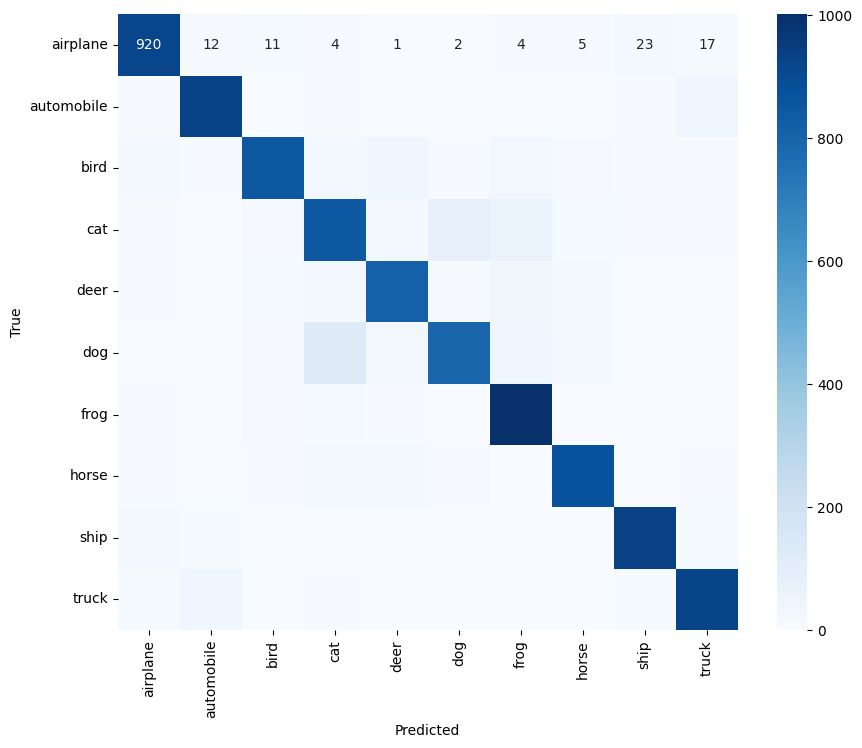

In [ ]:
mixer_ensemble_model = Ensemble(mixer_experts)
evaluate_and_plot(mixer_ensemble_model, test_loader)

Wow now that's impressive, at 89% accuracy on the test set. 